In [13]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import scipy.stats as stats
import seaborn as sns

Import the data for calibration

In [14]:
inflationEuro = pd.read_csv('inflation_euro_processed.csv')
euribor3Month = pd.read_csv('euribor_3_month_processed.csv')
bund10Years = pd.read_csv('bund_10_years_processed.csv')
spreadShortLongRates = pd.read_csv('spread_short_long_rates_processed.csv')
stoxx50E = pd.read_csv('stoxx50E_processed.csv')
IEIFIndex = pd.read_csv('IEIFindex_processed.csv')

df_inflation = pd.read_csv("ols_model_residuals_inflation.csv")
df_long_term_interest = pd.read_csv("ols_model_residuals_long_term.csv")
df_spread = pd.read_csv("ols_model_residuals_spread.csv")
df_stock = pd.read_csv("stock_residuals.csv")
df_realestate = pd.read_csv("real_estate_residuals.csv")

df_inflation.rename(columns={'residuals': 'Inflation', 'DATE': 'Date'}, inplace=True)
df_long_term_interest.rename(columns={'residuals': 'Long Terms', 'time_period': 'Date'}, inplace=True)
df_stock.rename(columns={'residuals': 'Stocks'}, inplace=True)
df_realestate.rename(columns={'residuals': 'Real Estate'}, inplace=True)
df_spread.rename(columns={'residuals': 'Spread', 'time_period': 'Date'}, inplace=True)

df_inflation['YEAR_MONTH'] = pd.to_datetime(df_inflation['YEAR_MONTH'])
df_inflation = df_inflation[['YEAR_MONTH', 'Inflation']]

df_long_term_interest['YEAR_MONTH'] = pd.to_datetime(df_long_term_interest['YEAR_MONTH'])
df_long_term_interest = df_long_term_interest[['YEAR_MONTH', 'Long Terms']]

df_stock['YEAR_MONTH'] = pd.to_datetime(df_stock['YEAR_MONTH'])
df_stock = df_stock[['YEAR_MONTH', 'Stocks']]

df_realestate['YEAR_MONTH'] = pd.to_datetime(df_realestate['YEAR_MONTH'])
df_realestate = df_realestate[['YEAR_MONTH', 'Real Estate']]

df_spread['YEAR_MONTH'] = pd.to_datetime(df_spread['YEAR_MONTH'])
df_spread = df_spread[['YEAR_MONTH', 'Spread']]

df_merged = pd.merge(df_inflation, df_long_term_interest, on='YEAR_MONTH', how='inner')
df_merged = pd.merge(df_merged, df_stock, on='YEAR_MONTH', how='inner')
df_merged = pd.merge(df_merged, df_realestate, on='YEAR_MONTH', how='inner')
df_merged = pd.merge(df_merged, df_spread, on='YEAR_MONTH', how='inner')

df_merged.set_index('YEAR_MONTH', inplace=True)

In [15]:
class BlackScholes:
    """
    Black–Scholes model for asset prices using the closed-form discretization.
    
    S_{t+1} = S_t * exp((μ - 0.5σ²) dt + σ √(dt) ε_t).
    """
    def __init__(self, dt, mu=None, sigma=None):
        self.mu = mu
        self.sigma = sigma
        self.calibrated = False
        self.dt = dt

    def calibrate(self, log_returns):
        """
        Calibrate mu and sigma from historical prices using log-returns.
        
        Let r = ln(S_t/S_{t-1}) ~ N((μ - 0.5σ²) dt, σ² dt).
        Then:
          σ = sqrt(var(r) / dt)
          μ = (mean(r)/dt) + 0.5 σ².
        """
        '''sigma_est = np.sqrt(np.var(log_returns, ddof=1) / self.dt)
        mu_est = (np.mean(log_returns) / self.dt) + 0.5 * sigma_est**2'''
        mu_est = np.mean(log_returns)
        sigma_est = np.std(log_returns)
        self.mu = mu_est
        self.sigma = sigma_est
        self.calibrated = True
        return mu_est, sigma_est

    def simulate(self, S0, num_steps, num_paths):
        """
        Simulate asset prices using Black–Scholes model (stochastic).
        """
        S = np.zeros((num_steps+1, num_paths))
        S[0, :] = S0
        for t in range(1, num_steps+1):
            dW = np.random.normal(0, 1, num_paths)
            S[t, :] = S[t-1, :] * np.exp((self.mu - 0.5 * self.sigma**2) * self.dt + self.sigma * np.sqrt(self.dt) * dW)
        return S

    def simulate_deterministic(self, S0, num_steps, num_paths):
        """
        Simulate the deterministic part (no noise) of the Black–Scholes model.
        
        S_{t+1} = S_t * exp((μ - 0.5σ²) dt).
        """
        S = np.zeros((num_steps+1, num_paths))
        S[0, :] = S0
        for t in range(1, num_steps+1):
            S[t, :] = S[t-1, :] * np.exp((self.mu - 0.5 * self.sigma**2) * self.dt)
        return S

    def plot_paths(self, time_axis, simulated_paths, average=None, deterministic=None, calibration_data=None):
        """
        Plot simulated asset paths along with the average and optionally the deterministic forecast
        and calibration data.
        """
        plt.figure(figsize=(10, 6))
        plt.title("Black–Scholes Model - Simulated Asset Paths")
        plt.xlabel("Time (years)")
        plt.ylabel("Asset Price")
        num_paths = simulated_paths.shape[1]
        for i in range(num_paths):
            plt.plot(time_axis, simulated_paths[:, i], lw=0.8, alpha=0.3, color='blue')
        if average is not None:
            plt.plot(time_axis, average, color='black', linestyle='--', lw=3, label='Average (Stochastic)')
        if deterministic is not None:
            plt.plot(time_axis, np.mean(deterministic, axis=1), color='green', linestyle='-', lw=3, label='Deterministic')
        if calibration_data is not None:
            calibration_data = np.asarray(calibration_data)
            if len(calibration_data) != len(time_axis):
                obs_time = np.linspace(time_axis[0], time_axis[-1], len(calibration_data))
                calibration_data = np.interp(time_axis, obs_time, calibration_data)
            plt.plot(time_axis, calibration_data, color='red', linestyle='-', lw=2, label='Real Data')
        plt.legend()
        plt.show()

class Vasicek:
    """
    Vasicek (Ornstein–Uhlenbeck) model for interest rates using the exact discretization
    as presented in the paper.
    
    The exact discretization is:
    
        r_{t+1} = μ (1 - exp(-a dt)) + exp(-a dt) r_t + σ √((1 - exp(-2a dt))/(2a)) ε_t
        
    where ε_t ~ N(0, 1).
    """
    def __init__(self, dt):
        self.calibrated = False
        self.a = None       
        self.mu = None      
        self.sigma = None   
        self.dt = dt

    def calibrate_ols(self, r):
        """
        Calibrate the Vasicek model parameters using Ordinary Least Squares (OLS).

        Parameters
        ----------
        r : array-like
            1D array of observed interest rates.
        dt : float
            Time step in years.

        Returns
        -------
        a_est : float
            Estimated speed of mean reversion.
        mu_est : float
            Estimated long-term mean level.
        sigma_est : float
            Estimated volatility.
        results : RegressionResults
            The full OLS regression results.
        """
        r = np.asarray(r).flatten()
        X = r[:-1]
        Y = r[1:]
        X_const = sm.add_constant(X)
        model = sm.OLS(Y, X_const)
        results = model.fit()
        
        alpha = results.params[0]
        beta = results.params[1]
        
        a_est = -np.log(beta) / self.dt
        mu_est = alpha / (1 - beta)
        
        mse = results.mse_resid
        sigma_est = np.sqrt(mse * (2 * a_est / (1 - np.exp(-2 * a_est * self.dt))))
        
        self.a = a_est
        self.mu = mu_est
        self.sigma = sigma_est
        self.calibrated = True
        
        return a_est, mu_est, sigma_est, results

    def calibrate_mle(self, r):
        """
        Calibrate the Vasicek model parameters using Maximum Likelihood Estimation (MLE).

        Parameters
        ----------
        r : array-like
            1D array of observed interest rates.
        dt : float
            Time step in years.

        Returns
        -------
        a_est : float
            Estimated speed of mean reversion.
        mu_est : float
            Estimated long-term mean level.
        sigma_est : float
            Estimated volatility.
        """
        r = np.asarray(r).flatten()
        n = len(r)
        S0 = np.sum(r[:-1]) / (n - 1)
        S1 = np.sum(r[1:]) / (n - 1)
        S00 = np.sum(r[:-1]**2) / (n - 1)
        S01 = np.sum(r[:-1] * r[1:]) / (n - 1)
        
        b_MLE = (S1 * S00 - S0 * S01) / (S0 * S1 - S0**2 - S01 + S00)
        a_est = 1 / self.dt * np.log((S0 - b_MLE) / (S1 - b_MLE))
        
        temp = 0
        for i in range(n - 1):
            m_i = r[i] * np.exp(-a_est * self.dt) + b_MLE * (1 - np.exp(-a_est * self.dt))
            temp += (r[i + 1] - m_i) ** 2
        sigma_est = np.sqrt((2 * a_est / (1 - np.exp(-2 * a_est * self.dt))) * (temp / (n - 1)))
        
        self.a = a_est
        self.mu = b_MLE
        self.sigma = sigma_est
        self.calibrated = True
        
        return a_est, b_MLE, sigma_est

    def simulate_exact(self, r0, num_steps, num_paths, a=None, mu=None, sigma=None):
        """
        Simulate the Vasicek model using the exact discretization.
        
        Parameters
        ----------
        r0 : float
            Initial interest rate.
        num_steps : int
            Number of time steps.
        num_paths : int
            Number of simulation paths.
        a : float, optional
            Speed of mean reversion. If not provided, the calibrated value is used.
        mu : float, optional
            Long-term mean level. If not provided, the calibrated value is used.
        sigma : float, optional
            Volatility. If not provided, the calibrated value is used.
        
        Returns
        -------
        rates : ndarray
            Simulated interest rate paths of shape (num_steps+1, num_paths).
        """
        
        if a is None or mu is None or sigma is None:
            if self.calibrated:
                a = self.a
                mu = self.mu
                sigma = self.sigma
            else:
                raise ValueError("Parameters not provided and the model is not calibrated.")
                
        rates = np.zeros((num_steps + 1, num_paths))
        rates[0, :] = r0
        
        exp_term = np.exp(-a * self.dt)
        drift = mu * (1 - exp_term)
        vol_factor = sigma * np.sqrt((1 - np.exp(-2 * a * self.dt)) / (2 * a))
        
        for t in range(1, num_steps + 1):
            dW = np.random.normal(0, 1, num_paths)
            rates[t, :] = drift + exp_term * rates[t - 1, :] + vol_factor * dW
            
        return rates
    
    def simulate_deterministic(self, r0, num_steps, num_paths, a=None, mu=None):
        """
        Simulate the deterministic (backtest) part by omitting the stochastic noise.
        
        r_{t+1} = μ (1 - exp(-a dt)) + exp(-a dt) * r_t.
        """
        if a is None or mu is None:
            if self.calibrated:
                a, mu = self.a, self.mu
            else:
                raise ValueError("Parameters not provided and model not calibrated.")
        rates = np.zeros((num_steps+1, num_paths))
        rates[0, :] = r0
        exp_term = np.exp(-a * self.dt)
        drift = mu * (1 - exp_term)
        for t in range(1, num_steps+1):
            rates[t, :] = drift + exp_term * rates[t-1, :]
        return rates

    def plot_paths(self, time_axis, simulated_paths, average, upper_bound, lower_bound, deterministic=None, calibration_data=None):
        """
        Plot simulated paths along with average and bounds.
        
        Optionally, overlay the deterministic simulation and calibration data.
        """
        plt.figure(figsize=(10, 6))
        plt.title('Vasicek Model - Simulated Interest Rate Paths')
        plt.xlabel('Time (years)')
        plt.ylabel('Interest Rate')
        num_paths = simulated_paths.shape[1]
        for i in range(num_paths):
            plt.plot(time_axis, simulated_paths[:, i], lw=0.8, alpha=0.3, color='blue')
        plt.plot(time_axis, average, color='black', linestyle='--', lw=3, label='Average (Stochastic)')
        plt.plot(time_axis, upper_bound, color='grey', linestyle='--', lw=2, label='Upper Bound (2σ)')
        plt.plot(time_axis, lower_bound, color='grey', linestyle='--', lw=2, label='Lower Bound (2σ)')
        if deterministic is not None:
            plt.plot(time_axis, np.mean(deterministic, axis=1), color='green', linestyle='-', lw=3, label='Deterministic')
        if calibration_data is not None:
            calibration_data = np.asarray(calibration_data)
            if len(calibration_data) != len(time_axis):
                obs_time = np.linspace(time_axis[0], time_axis[-1], len(calibration_data))
                calibration_data = np.interp(time_axis, obs_time, calibration_data)
            plt.plot(time_axis, calibration_data, color='red', linestyle='-', lw=2, label='Real Data')
        plt.legend()
        plt.show()

In [16]:
class EconomicScenarioGenerator:
    """
    Economic Scenario Generator (GSE) class that ties together:
      - Vasicek models (for inflation, interest rates, spread)
      - Black-Scholes models (for stocks, real estate)
      - Correlation structure among all shocks
      - Multi-step scenario projection
    """

    def __init__(self,
                 dt,
                 vasicek_inflation=None,
                 vasicek_interest=None,
                 vasicek_spread=None,
                 black_scholes_equity=None,
                 black_scholes_realestate=None,
                 corr_matrix=None):
        """
        Parameters
        ----------
        vasicek_inflation : Vasicek
            Calibrated Vasicek model instance for inflation.
        vasicek_interest : Vasicek
            Calibrated Vasicek model instance for interest rates (e.g. for the long rate).
        vasicek_spread : Vasicek
            Calibrated Vasicek model instance for the spread (long rate - short rate).
            (Or you might have separate short-rate and long-rate Vasicek models.)
        black_scholes_equity : BlackScholes
            Calibrated Black-Scholes model instance for equity.
        black_scholes_realestate : BlackScholes
            Calibrated Black-Scholes model instance for real estate.
        corr_matrix : np.ndarray
            Correlation matrix among the random shocks of each process, shape (n, n).
            Here 'n' is the total dimension (# of processes).
        """

        self.vasicek_inflation = vasicek_inflation
        self.vasicek_interest = vasicek_interest
        self.vasicek_spread = vasicek_spread
        self.bs_equity = black_scholes_equity
        self.bs_re = black_scholes_realestate

        self.dt = dt

        self.corr_matrix = corr_matrix
        if corr_matrix is not None:
            self.dim = corr_matrix.shape[0]
        else:
            self.dim = 0

        if corr_matrix is not None:
            self.cholesky = np.linalg.cholesky(corr_matrix)
        else:
            self.cholesky = None

    def simulate_scenarios(self,
                           n_scenarios=1000,
                           num_steps=10,
                           inflation_init=None,
                           interest_init=None,
                           spread_init=None,
                           equity_init=None,
                           realestate_init=None):
        """
        Simulate correlated scenarios for inflation, interest rates, spread, equity, and real estate.

        Parameters
        ----------
        n_scenarios : int
            Number of simulation paths.
        num_steps : int
            Number of time steps (e.g. T=5, num_steps=5 -> annual steps).
        inflation_init : float
            Initial inflation observation.
        interest_init : float
            Initial interest-rate observation (e.g. 10y rate).
        spread_init : float
            Initial spread (e.g. 10y rate - 3m rate).
        equity_init : float
            Initial equity index level.
        realestate_init : float
            Initial real estate index level.

        Returns
        -------
        results : dict of np.ndarrays
            Dictionary with keys = ['inflation','interest','spread','equity','realestate']
            Each value is an array of shape (num_steps+1, n_scenarios) containing the simulated paths.
        """

        inflation_paths = np.zeros((num_steps + 1, n_scenarios))
        interest_paths = np.zeros((num_steps + 1, n_scenarios))
        spread_paths = np.zeros((num_steps + 1, n_scenarios))
        equity_paths = np.zeros((num_steps + 1, n_scenarios))
        re_paths = np.zeros((num_steps + 1, n_scenarios))

        inflation_paths[0, :] = inflation_init if inflation_init is not None else 0.02
        interest_paths[0, :] = interest_init if interest_init is not None else 0.01
        spread_paths[0, :] = spread_init if spread_init is not None else 0.01
        equity_paths[0, :] = equity_init if equity_init is not None else 100.0
        re_paths[0, :] = realestate_init if realestate_init is not None else 100.0

        for t in range(1, num_steps + 1):
            z = np.random.normal(0, 1, (self.dim, n_scenarios))

            if self.cholesky is not None:
                correlated_shocks = self.cholesky @ z
            else:
                correlated_shocks = z  

            eps_inflation = correlated_shocks[0, :]
            eps_interest = correlated_shocks[1, :]
            eps_equity = correlated_shocks[3, :]
            eps_re = correlated_shocks[4, :]
            eps_spread = correlated_shocks[2, :]

            old_inflation = inflation_paths[t-1, :]
            if self.vasicek_inflation is not None:
                a_i = self.vasicek_inflation.a
                mu_i = self.vasicek_inflation.mu
                sigma_i = self.vasicek_inflation.sigma

                exp_term = np.exp(-a_i*self.dt)
                drift = mu_i * (1 - exp_term)
                vol = sigma_i * np.sqrt((1 - np.exp(-2*a_i*self.dt)) / (2*a_i))

                new_inflation = drift + exp_term * old_inflation + vol * eps_inflation
                inflation_paths[t, :] = new_inflation
            else:
                inflation_paths[t, :] = old_inflation

            old_interest = interest_paths[t-1, :]
            if self.vasicek_interest is not None:
                a_l = self.vasicek_interest.a
                mu_l = self.vasicek_interest.mu
                sigma_l = self.vasicek_interest.sigma

                exp_term_l = np.exp(-a_l*self.dt)
                drift_l = mu_l * (1 - exp_term_l)
                vol_l = sigma_l * np.sqrt((1 - np.exp(-2*a_l*self.dt)) / (2*a_l))

                new_long_rate = drift_l + exp_term_l * old_interest + vol_l * eps_interest
                interest_paths[t, :] = new_long_rate
            else:
                interest_paths[t, :] = old_interest

            old_spread = spread_paths[t-1, :]
            if self.vasicek_spread is not None:
                a_s = self.vasicek_spread.a
                mu_s = self.vasicek_spread.mu
                sigma_s = self.vasicek_spread.sigma

                exp_term_s = np.exp(-a_s*self.dt)
                drift_s = mu_s * (1 - exp_term_s)
                vol_s = sigma_s * np.sqrt((1 - np.exp(-2*a_s*self.dt)) / (2*a_s))

                new_spread = drift_s + exp_term_s*old_spread + vol_s * eps_spread
                spread_paths[t, :] = new_spread
            else:
                spread_paths[t, :] = old_spread

            old_equity = equity_paths[t-1, :]
            if self.bs_equity is not None:
                mu_eq = self.bs_equity.mu
                sigma_eq = self.bs_equity.sigma

                drift_eq = (mu_eq - 0.5*sigma_eq**2) * self.dt
                diff_eq = sigma_eq * np.sqrt(self.dt) * eps_equity

                new_equity = old_equity * np.exp(drift_eq + diff_eq)
                equity_paths[t, :] = new_equity
            else:
                equity_paths[t, :] = old_equity

            old_re = re_paths[t-1, :]
            if self.bs_re is not None:
                mu_re = self.bs_re.mu
                sigma_re = self.bs_re.sigma

                drift_re = (mu_re - 0.5*sigma_re**2) * self.dt
                diff_re = sigma_re * np.sqrt(self.dt) * eps_re

                new_realestate = old_re * np.exp(drift_re + diff_re)
                re_paths[t, :] = new_realestate
            else:
                re_paths[t, :] = old_re

        results = {
            'inflation': inflation_paths,
            'interest': interest_paths,
            'spread': spread_paths,
            'equity': equity_paths,
            'realestate': re_paths
        }
        return results

    def plot_scenarios(self, results, time_axis=None, show=True):
        """
        Simple helper to plot the simulation paths for each variable.
        """
        if time_axis is None:
            steps = results['inflation'].shape[0]
            time_axis = np.arange(steps)

        fig, ax = plt.subplots(3, 2, figsize=(12, 10))  

        for i in range(results['inflation'].shape[1]):
            ax[0,0].plot(time_axis, results['inflation'][:, i], alpha=0.2, color='blue')
        ax[0,0].set_title("Inflation")

        for i in range(results['interest'].shape[1]):
            ax[0,1].plot(time_axis, results['interest'][:, i], alpha=0.2, color='green')
        ax[0,1].set_title("Long Rate")

        for i in range(results['spread'].shape[1]):
            ax[1,0].plot(time_axis, results['spread'][:, i], alpha=0.2, color='red')
        ax[1,0].set_title("Spread")

        for i in range(results['equity'].shape[1]):
            ax[1,1].plot(time_axis, results['equity'][:, i], alpha=0.2, color='magenta')
        ax[1,1].set_title("Equity")

        for i in range(results['realestate'].shape[1]):
            ax[2,0].plot(time_axis, results['realestate'][:, i], alpha=0.2, color='brown')
        ax[2,0].set_title("Real Estate")

        ax[2,1].axis('off')

        plt.tight_layout()
        if show:
            plt.show()

    def plot_scenarios_with_quantiles(
            self,
            historical_data,
            results,
            variable: str,
            dt_hist: float,
            dt_future: float,
            num_steps: int,
            title: str = None,
            xlabel: str = "Time (years)",
            ylabel: str = ""
        ):
        """
        Plot historical data (for one economic variable) and the simulated scenarios
        on the same time axis, showing only the 5%, 25%, 75%, 95% quantiles,
        and the mean of the simulated paths.

        Parameters
        ----------
        historical_data : 1D array-like
            Historical observations of the variable to be plotted.
            (e.g. an array of monthly inflation or interest rates.)
        results : dict of np.ndarray
            The dictionary returned by `simulate_scenarios`.
            E.g. results['interest'] has shape (num_steps+1, n_scenarios).
        variable : str
            One of 'inflation', 'interest', 'spread', 'equity', 'realestate'.
            Used to pick the correct array from `results`.
        dt_hist : float
            Time-step for the historical data, in years.
            For monthly data, dt_hist = 1/12.
        dt_future : float
            Time-step used in the simulation (same as self.dt typically), in years.
            For monthly steps, dt_future = 1/12.
        num_steps : int
            Number of future steps (e.g. 10 if you are projecting 10 more steps).
        title : str, optional
            Title for the figure.
        xlabel : str, optional
            Label for the x-axis.
        ylabel : str, optional
            Label for the y-axis.
        """

        import matplotlib.pyplot as plt
        import numpy as np

        hist_data = np.asarray(historical_data)
        n_hist = len(hist_data)

        time_hist = np.arange(n_hist) * dt_hist

        simulated_data = results[variable]

        start_future = time_hist[-1]  
        time_future = start_future + np.arange(num_steps + 1) * dt_future

        q05 = np.quantile(simulated_data, 0.05, axis=1)
        q25 = np.quantile(simulated_data, 0.25, axis=1)
        q75 = np.quantile(simulated_data, 0.75, axis=1)
        q95 = np.quantile(simulated_data, 0.95, axis=1)
        mean_ = np.mean(simulated_data, axis=1)

        fig, ax = plt.subplots(figsize=(10, 6))

        ax.plot(time_hist, hist_data, color='black', lw=2, label='Historical Data')

        ax.plot(time_future, mean_, color='blue', lw=2, label='Mean (Simulated)')

        ax.fill_between(time_future, q05, q95, color='blue', alpha=0.1, label='5%-95% range')

        ax.fill_between(time_future, q25, q75, color='blue', alpha=0.2, label='25%-75% range')

        ax.set_xlim(0, max(time_hist[-1], time_future[-1]))

        if title is None:
            title = f"{variable.capitalize()} - Historical + Projected"
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='best')

        plt.grid(True)
        plt.show()

Copule

In [17]:
corr_matrix = df_merged.corr()  
print(corr_matrix.round(3)*100)

             Inflation  Long Terms  Stocks  Real Estate  Spread
Inflation        100.0        17.3     3.9          1.7    -5.0
Long Terms        17.3       100.0    21.0          1.5    65.9
Stocks             3.9        21.0   100.0         69.7    11.4
Real Estate        1.7         1.5    69.7        100.0     3.5
Spread            -5.0        65.9    11.4          3.5   100.0


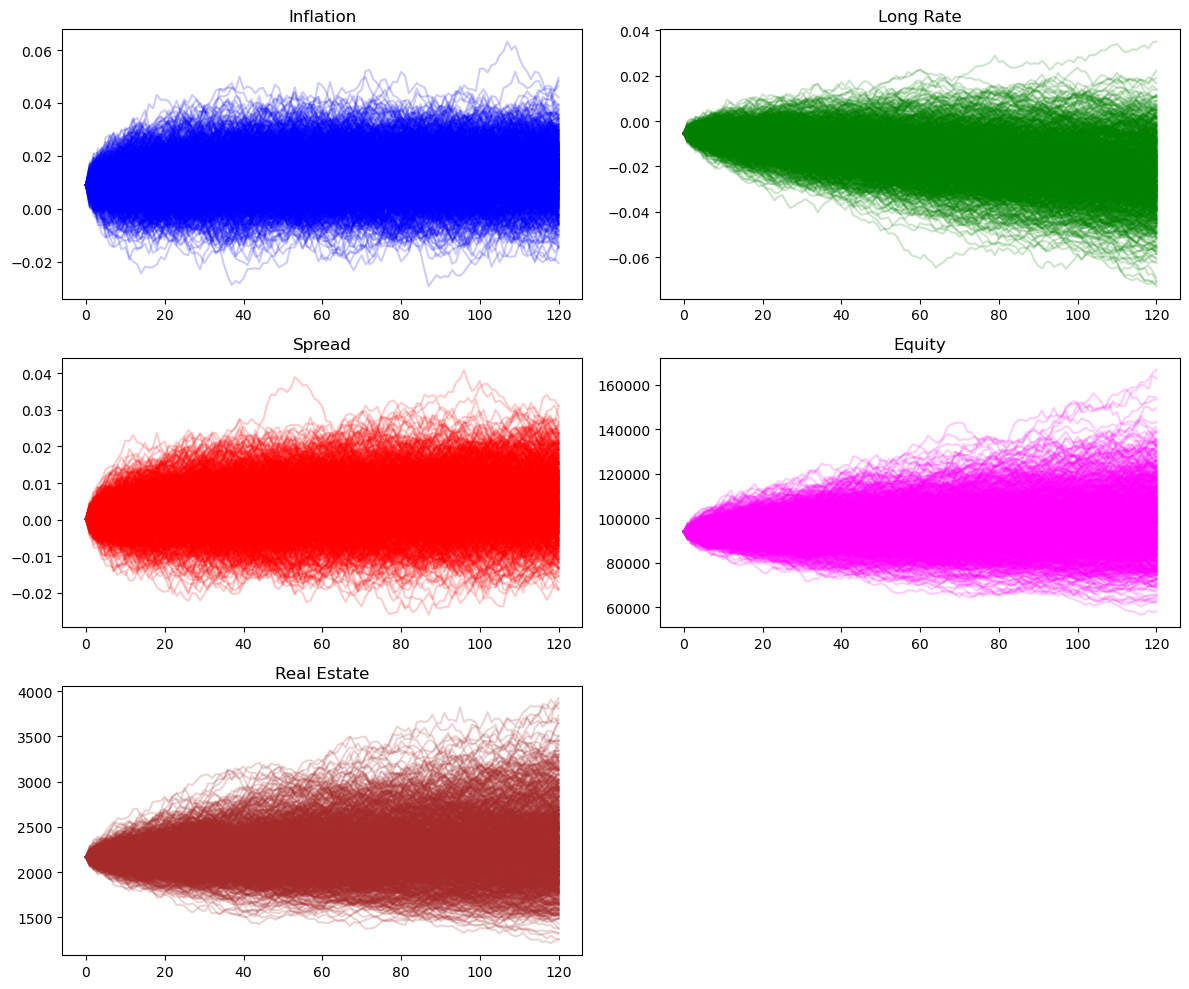

In [18]:
dt = 1/12 # Monthly data

inflationEuro_data = inflationEuro.inflation.values
vasicek_infl = Vasicek(dt)
vasicek_infl.calibrate_ols(r=inflationEuro_data)

bund_10_years_data = bund10Years.bund_10_years.values
vasicek_long = Vasicek(dt)
vasicek_long.calibrate_ols(r=bund_10_years_data)

# For residuals 
a_long, mu_long, sigma_long, results_long = vasicek_long.calibrate_ols(bund_10_years_data)
bund10Years = bund10Years.iloc[1:]
bund10Years["bund_resid"] = results_long.resid

spreadShortLongRates_data = spreadShortLongRates.spread.values
vasicek_sprd = Vasicek(dt)
vasicek_sprd.calibrate_ols(r=spreadShortLongRates_data)

# For residuals
a_spread, mu_spread, sigma_spread, results_spread = vasicek_sprd.calibrate_ols(spreadShortLongRates_data)
spreadShortLongRates = spreadShortLongRates.iloc[1:]
spreadShortLongRates["spread_resid"] = results_spread.resid

stoxx50E_data = stoxx50E.log_returns.values
bs_equity = BlackScholes(dt)
bs_equity.calibrate(stoxx50E_data)

IEIFIndex_data = IEIFIndex.log_returns.values
bs_re = BlackScholes(dt)
bs_re.calibrate(IEIFIndex_data)

# For residuals
re_mean = IEIFIndex_data.mean()
re_resid = IEIFIndex_data - re_mean
IEIFIndex["re_resid"] = re_resid

gse = EconomicScenarioGenerator(
    vasicek_inflation=vasicek_infl,
    vasicek_interest=vasicek_long,
    vasicek_spread=vasicek_sprd,
    black_scholes_equity=bs_equity,
    black_scholes_realestate=bs_re,
    corr_matrix=corr_matrix,
    dt=dt
)

n_scenarios = 1000
T = 10    
num_steps = int(T/dt)
init_infl = inflationEuro_data[-1]  
init_long = bund_10_years_data[-1]     
init_spread = spreadShortLongRates_data[-1]  
#init_equity = stoxx50E_data[-1] 
#init_re = IEIFIndex_data[-1]   

init_equity = stoxx50E['EURO STOXX 50'].iloc[-1]  
init_re = IEIFIndex['IEIF_index'].iloc[-1]

results = gse.simulate_scenarios(n_scenarios=n_scenarios,
                                 num_steps=num_steps,
                                 inflation_init=init_infl,
                                 interest_init=init_long,
                                 spread_init=init_spread,
                                 equity_init=init_equity,
                                 realestate_init=init_re)


gse.plot_scenarios(results)

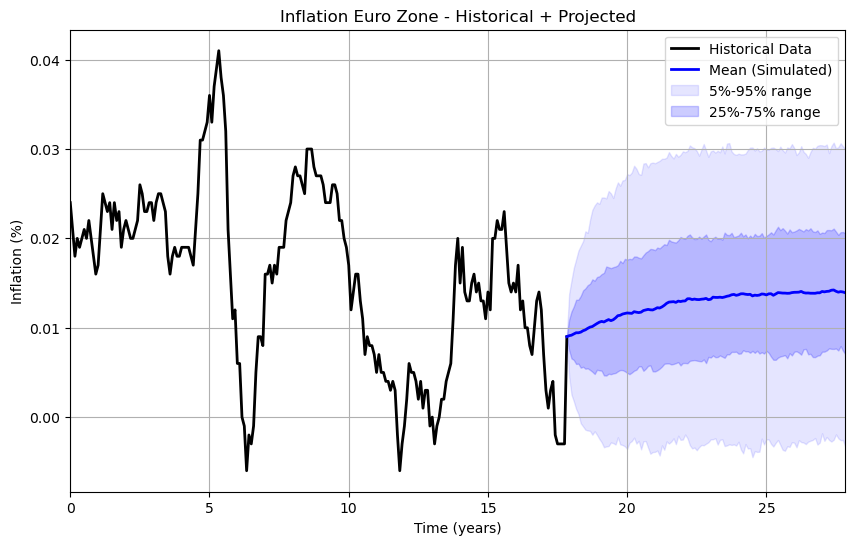

In [19]:
gse.plot_scenarios_with_quantiles(
    historical_data=inflationEuro['inflation'].values,  
    results=results,
    variable='inflation',
    dt_hist=dt,       
    dt_future=dt,    
    num_steps=int(T/dt),               
    title="Inflation Euro Zone - Historical + Projected",
    xlabel="Time (years)",
    ylabel="Inflation (%)"
)

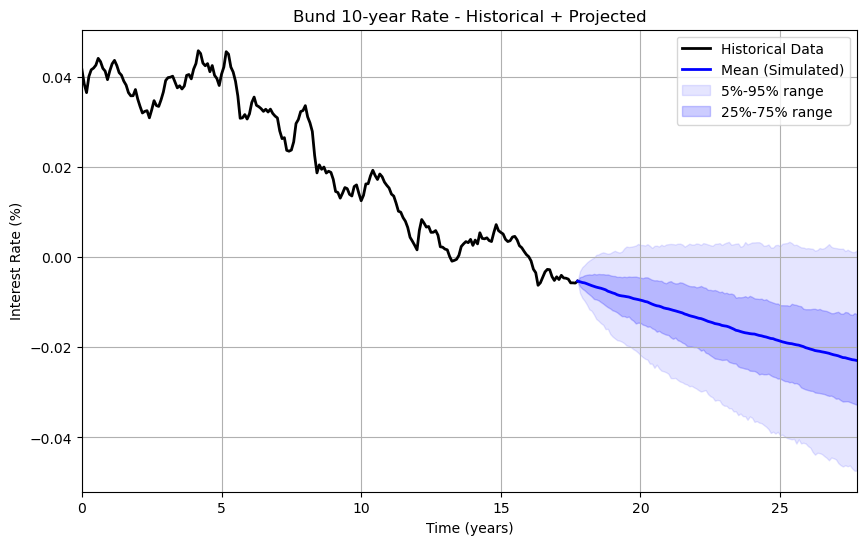

In [20]:
gse.plot_scenarios_with_quantiles(
    historical_data=bund10Years['bund_10_years'].values,  
    results=results,
    variable='interest',
    dt_hist=dt,       
    dt_future=dt,    
    num_steps=int(T/dt),              
    title="Bund 10-year Rate - Historical + Projected",
    xlabel="Time (years)",
    ylabel="Interest Rate (%)"
)

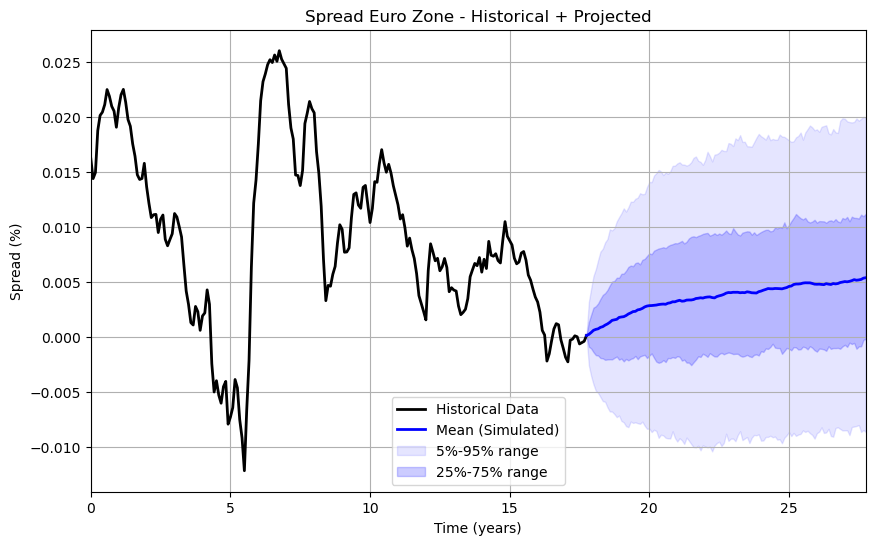

In [21]:
gse.plot_scenarios_with_quantiles(
    historical_data=spreadShortLongRates['spread'].values,  
    results=results,
    variable='spread',
    dt_hist=dt,       
    dt_future=dt,    
    num_steps=int(T/dt),
    title="Spread Euro Zone - Historical + Projected",
    xlabel="Time (years)",
    ylabel="Spread (%)"
)

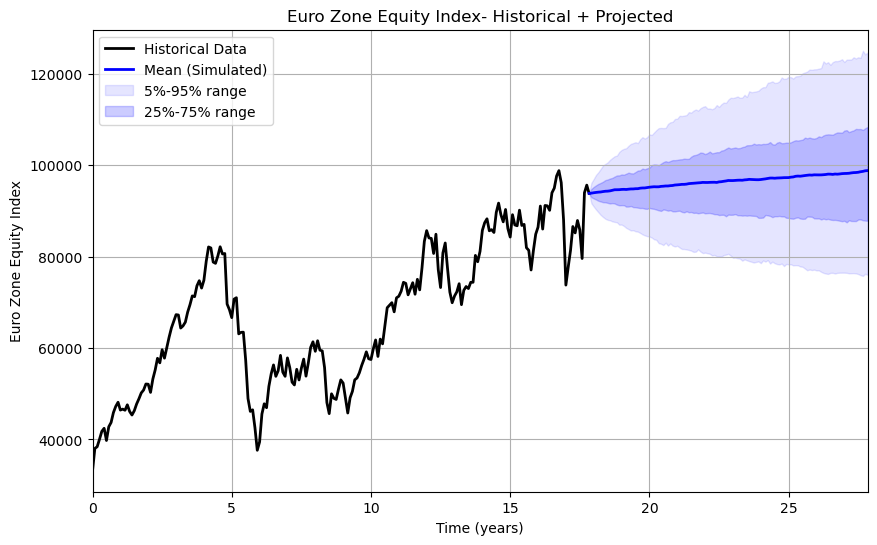

In [22]:
gse.plot_scenarios_with_quantiles(
    historical_data=stoxx50E['EURO STOXX 50'].values,  
    results=results,
    variable='equity',
    dt_hist=dt,       
    dt_future=dt,    
    num_steps=int(T/dt),         
    title="Euro Zone Equity Index- Historical + Projected",
    xlabel="Time (years)",
    ylabel="Euro Zone Equity Index"
)

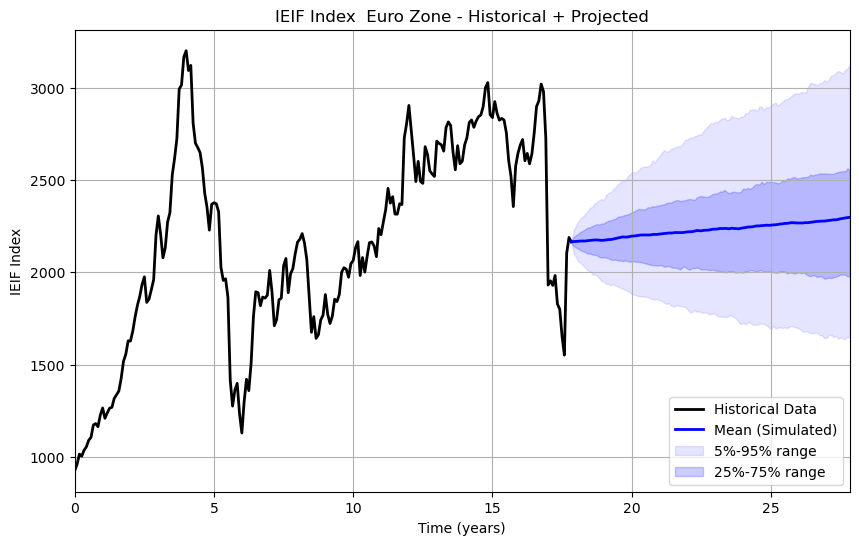

In [23]:
gse.plot_scenarios_with_quantiles(
    historical_data=IEIFIndex['IEIF_index'].values,  
    results=results,
    variable='realestate',
    dt_hist=dt,       
    dt_future=dt,    
    num_steps=int(T/dt),
    title="IEIF Index  Euro Zone - Historical + Projected",
    xlabel="Time (years)",
    ylabel="IEIF Index"
)

Hidden Markov Chain

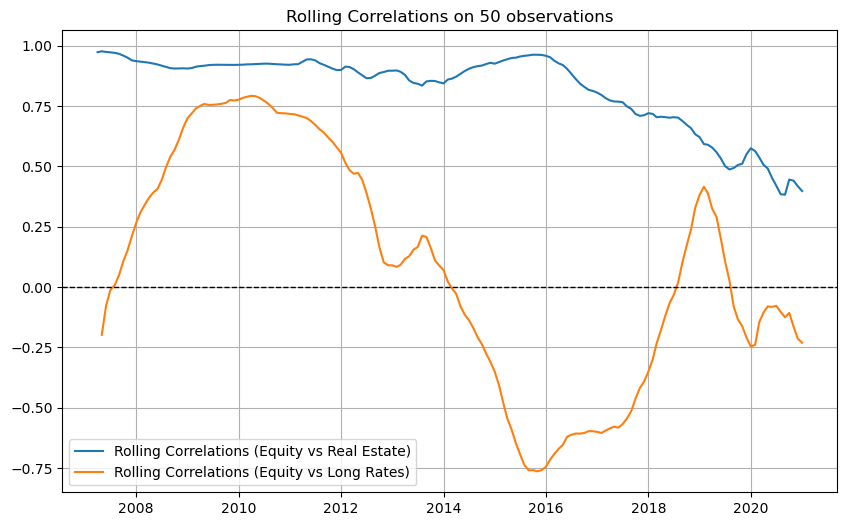

In [24]:
# Corrélations glissantes entre indice actions & indice immobilier

window_size = 50

rolling_corr_actions_immo = stoxx50E['EURO STOXX 50'].rolling(window_size).corr(IEIFIndex['IEIF_index'])

rolling_corr_actions_taux = stoxx50E['EURO STOXX 50'].rolling(window_size).corr(bund10Years['bund_10_years'])

stoxx50E['YEAR_MONTH'] = pd.to_datetime(stoxx50E['YEAR_MONTH'])

plt.figure(figsize=(10, 6))

plt.plot(stoxx50E.YEAR_MONTH, rolling_corr_actions_immo, label='Rolling Correlations (Equity vs Real Estate)')
plt.plot(stoxx50E.YEAR_MONTH, rolling_corr_actions_taux, label='Rolling Correlations (Equity vs Long Rates)')

plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title("Rolling Correlations on 50 observations")
plt.legend(loc='best')
plt.grid(True)
plt.show()

We observe a temporal instability in the dependance of assets, mainly due to financial crisis.
Hence, the use of a linear correlation matrix in the ESG is not optimal; many states of the world need to be introduced dans projection models of financial assets. 
The use of correlation matrix for each state of the world will allow to take into account the temporality of the dependance between assets.

In [25]:
from hmmlearn import hmm

ModuleNotFoundError: No module named 'hmmlearn'

## Inflation

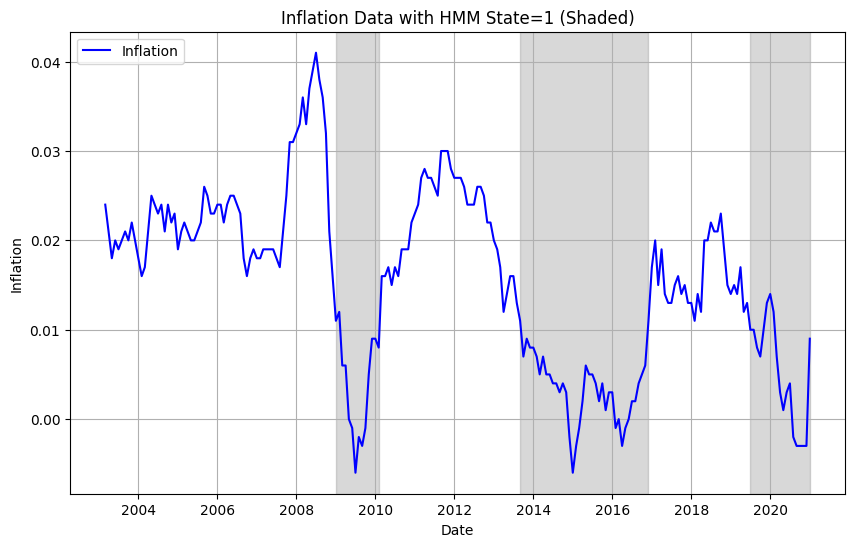

In [ ]:
inflationEuro["YEAR_MONTH"] = pd.to_datetime(inflationEuro["YEAR_MONTH"])

inflationEuro_data = inflationEuro["inflation"].values

model_inflation = hmm.GaussianHMM(n_components=2, n_iter=1000)
X = inflationEuro_data.reshape(-1, 1)  
model_inflation.fit(X)

pred_states = model_inflation.predict(X)
inflationEuro['inflation_state'] = pred_states

def contiguous_regions(condition):
    """
    Returns a list of (start, end) indices for each contiguous True
    block in a boolean array 'condition'.
    """
    diff = np.diff(condition)
    idx, = diff.nonzero()
    idx += 1

    if condition[0]:
        idx = np.r_[0, idx]

    if condition[-1]:
        idx = np.r_[idx, condition.size]

    idx = idx.reshape((-1, 2))
    return idx

mask_state_1 = (pred_states == 1)
regions_state_1 = contiguous_regions(mask_state_1)

fig, ax = plt.subplots(figsize=(10, 6))

dates = inflationEuro["YEAR_MONTH"]

ax.plot(dates, inflationEuro_data, label="Inflation", color='blue')

for start_idx, end_idx in regions_state_1:
    ax.axvspan(dates.iloc[start_idx], dates.iloc[end_idx - 1],
               color='gray', alpha=0.3)

ax.set_title("Inflation Data with HMM State=1 (Shaded)")
ax.set_xlabel("Date")
ax.set_ylabel("Inflation")
ax.legend()
ax.grid(True)

plt.show()

Calibration

In [ ]:
data_state0 = inflationEuro_data[pred_states == 0]
data_state1 = inflationEuro_data[pred_states == 1]

idx_0 = inflationEuro.index[inflationEuro["inflation_state"] == 0]
idx_0_aligned = idx_0[:-1]
r0 = inflationEuro.loc[idx_0_aligned, "inflation"].values

idx_1 = inflationEuro.index[inflationEuro["inflation_state"] == 1]
idx_1_aligned = idx_1[:-1]
r1 = inflationEuro.loc[idx_1_aligned, "inflation"].values

In [ ]:
vasicek_0 = Vasicek(dt)
a0, mu0, sigma0, _0 = vasicek_0.calibrate_ols(r0)

vasicek_1 = Vasicek(dt)
a1, mu1, sigma1, _1 = vasicek_1.calibrate_ols(r1)

print("Regime 0 Vasicek params (stable state):")
print(f'Speed of mean reversion: {np.round(a0, 2)} %')
print(f'Long term mean: {np.round(mu0, 2)} %')
print(f'Sigma: {np.round(sigma0, 2)} %')
print(f'Probablity of state 1 to 2: {np.round(model_inflation.transmat_[0:1,1] * 100, 2)} %')
print(f'R-Squared Adjusted: {np.round(_0.rsquared_adj * 100, 2)} %')


print("\nRegime 1 Vasicek params (crisis state):")
print(f'Speed of mean reversion: {np.round(a1, 2)} %')
print(f'Long term mean: {np.round(mu1, 2)} %')
print(f'Sigma: {np.round(sigma1, 2)} %')
print(f'Probablity of state 2 to 1: {np.round(model_inflation.transmat_[1:,0] * 100, 2)} %')
print(f'R-Squared Adjusted: {np.round(_1.rsquared_adj * 100, 2)} %')

Regime 0 Vasicek params (stable state):
Speed of mean reversion: 1.03 %
Long term mean: 0.02 %
Sigma: 0.01 %
Probablity of state 1 to 2: [2.19] %
R-Squared Adjusted: 82.65 %

Regime 1 Vasicek params (crisis state):
Speed of mean reversion: 2.08 %
Long term mean: 0.0 %
Sigma: 0.01 %
Probablity of state 2 to 1: [2.94] %
R-Squared Adjusted: 70.44 %


Normality of residuals

In [ ]:
# Shapiro Test of Normality

shapiro_test = stats.shapiro(_0.resid)
shapiro_test

ShapiroResult(statistic=0.9790425166018883, pvalue=0.03003804235871372)

In [ ]:
# Shapiro Test of Normality

shapiro_test = stats.shapiro(_1.resid)
shapiro_test

ShapiroResult(statistic=0.9775157269843764, pvalue=0.23200103927599647)

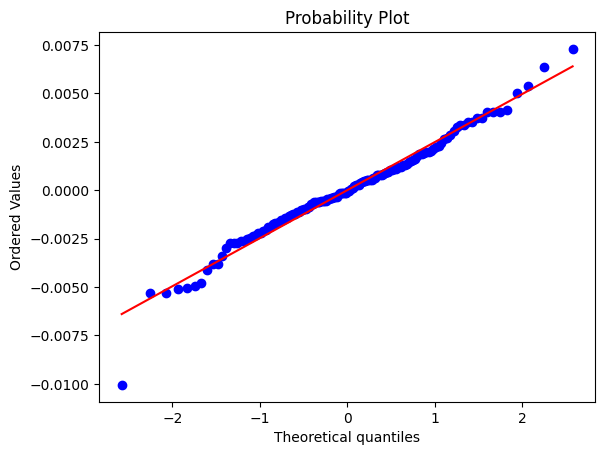

In [ ]:
## QQ-Plot against normal distribution

stats.probplot(_0.resid, dist='norm', plot=plt)
plt.show()

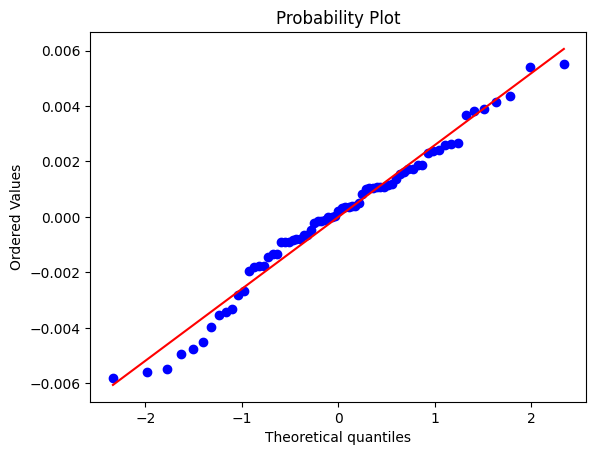

In [ ]:
## QQ-Plot against normal distribution

stats.probplot(_1.resid, dist='norm', plot=plt)
plt.show()

In [ ]:
idx_0_resid = idx_0_aligned[1:]
inflationEuro["inflation_resid_0"] = np.nan
inflationEuro.loc[idx_0_resid, "inflation_resid_0"] = _0.resid

idx_1_resid = idx_1_aligned[1:]
inflationEuro["inflation_resid_1"] = np.nan
inflationEuro.loc[idx_1_resid, "inflation_resid_1"] = _1.resid

Backtesting with deterministic path 

In [ ]:
def piecewise_deterministic_vasicek(data, states, dt, a0, mu0, a1, mu1):
    """
    Build a piecewise-deterministic path for 'data', using the state at each time.

    Parameters
    ----------
    data : 1D array
        Original data (e.g. inflation), length n.
    states : 1D array of integers
        HMM-predicted state at each time index, also length n.
        Values are 0 or 1 in this 2-state example.
    dt : float
        Time step in years (e.g. 1/12 if monthly).
    a0, mu0 : float
        Vasicek parameters for state 0 (speed, long-run mean).
    a1, mu1 : float
        Vasicek parameters for state 1.

    Returns
    -------
    r_det : 1D array
        Deterministic path, same length as data.
        r_det[0] = data[0], then each subsequent point
        uses the (a, mu) of the *current* state.
    """
    n = len(data)
    r_det = np.zeros(n)
    r_det[0] = data[0]  # start at the first observed value

    for t in range(n - 1):
        if states[t] == 0:
            exp_term = np.exp(-a0 * dt)
            drift = mu0 * (1 - exp_term)
            r_det[t+1] = drift + exp_term * r_det[t]
        else:
            exp_term = np.exp(-a1 * dt)
            drift = mu1 * (1 - exp_term)
            r_det[t+1] = drift + exp_term * r_det[t]

    return r_det

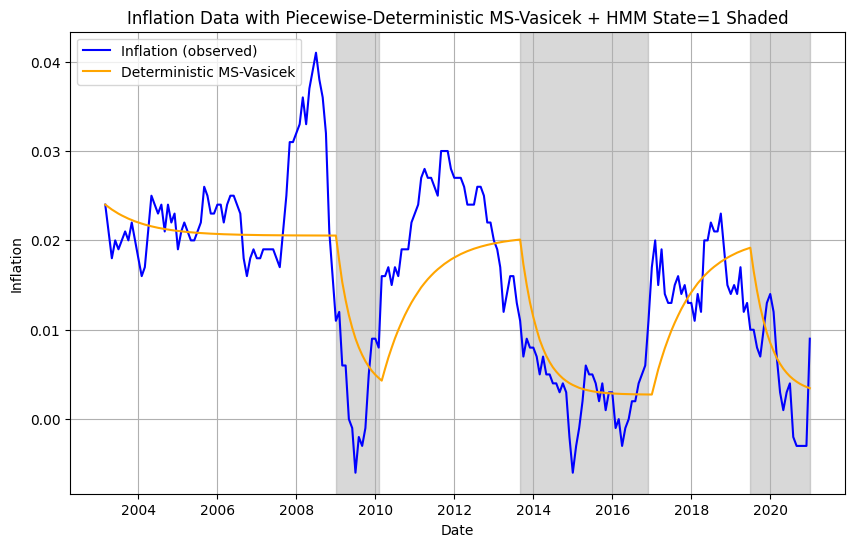

In [ ]:
r_det = piecewise_deterministic_vasicek(inflationEuro_data, pred_states, dt, a0, mu0, a1, mu1)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(dates, inflationEuro_data, label="Inflation (observed)", color='blue')

ax.plot(dates, r_det, label="Deterministic MS-Vasicek", color='orange')

for start_idx, end_idx in regions_state_1:
    ax.axvspan(dates.iloc[start_idx], dates.iloc[end_idx - 1],
               color='gray', alpha=0.3)

ax.set_title("Inflation Data with Piecewise-Deterministic MS-Vasicek + HMM State=1 Shaded")
ax.set_xlabel("Date")
ax.set_ylabel("Inflation")
ax.legend()
ax.grid(True)

plt.show()

## Interest Rates and Spread

### Long-Term Rates

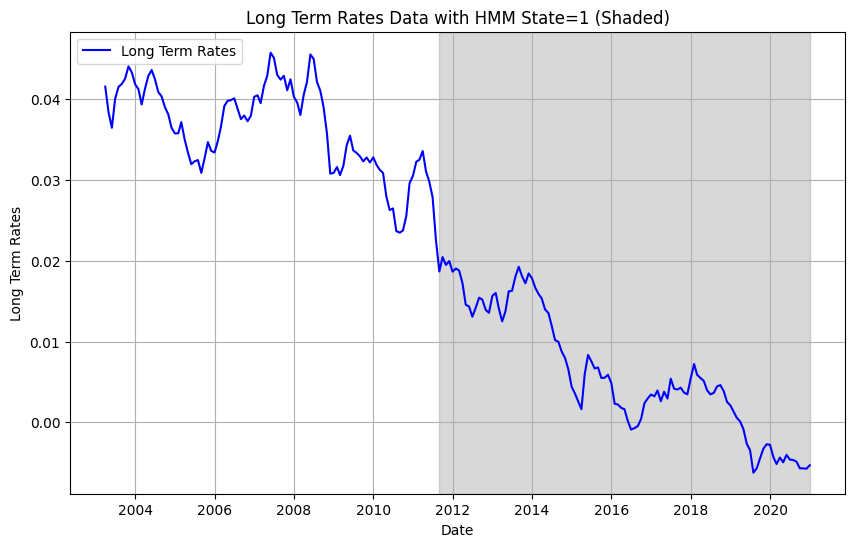

In [ ]:
bund10Years["YEAR_MONTH"] = pd.to_datetime(bund10Years["YEAR_MONTH"])

bund_10_years_data = bund10Years["bund_10_years"].values

model_lt = hmm.GaussianHMM(n_components=2, n_iter=1000)
X = bund_10_years_data.reshape(-1, 1)  
model_lt.fit(X)

pred_states = model_lt.predict(X)

def contiguous_regions(condition):
    """
    Returns a list of (start, end) indices for each contiguous True
    block in a boolean array 'condition'.
    """
    diff = np.diff(condition)
    idx, = diff.nonzero()
    idx += 1

    if condition[0]:
        idx = np.r_[0, idx]

    if condition[-1]:
        idx = np.r_[idx, condition.size]

    idx = idx.reshape((-1, 2))
    return idx

mask_state_1 = (pred_states == 1)
regions_state_1 = contiguous_regions(mask_state_1)

fig, ax = plt.subplots(figsize=(10, 6))

dates = bund10Years["YEAR_MONTH"]

ax.plot(dates, bund_10_years_data, label="Long Term Rates", color='blue')

for start_idx, end_idx in regions_state_1:
    ax.axvspan(dates.iloc[start_idx], dates.iloc[end_idx - 1],
               color='gray', alpha=0.3)

ax.set_title("Long Term Rates Data with HMM State=1 (Shaded)")
ax.set_xlabel("Date")
ax.set_ylabel("Long Term Rates")
ax.legend()
ax.grid(True)

plt.show()

Calibration

In [ ]:
data_state0 = bund_10_years_data[pred_states == 0]
data_state1 = bund_10_years_data[pred_states == 1]

In [ ]:
vasicek_0 = Vasicek(dt)
a0, mu0, sigma0, _0 = vasicek_0.calibrate_ols(data_state0)

vasicek_1 = Vasicek(dt)
a1, mu1, sigma1, _1 = vasicek_1.calibrate_ols(data_state1)

print("Regime 0 Vasicek params (stable state):")
print(f'Speed of mean reversion: {np.round(a0, 2)} %')
print(f'Long term mean: {np.round(mu0, 2)} %')
print(f'Sigma: {np.round(sigma0, 2)} %')
print(f'Probablity of state 1 to 2: {np.round(model_lt.transmat_[0:1,1] * 100, 2)} %')
print(f'R-Squared Adjusted: {np.round(_0.rsquared_adj * 100, 2)} %')


print("\nRegime 1 Vasicek params (crisis state):")
print(f'Speed of mean reversion: {np.round(a1, 2)} %')
print(f'Long term mean: {np.round(mu1, 2)} %')
print(f'Sigma: {np.round(sigma1, 2)} %')
print(f'Probablity of state 2 to 1: {np.round(model_lt.transmat_[1:,0] * 100, 2)} %')
print(f'R-Squared Adjusted: {np.round(_1.rsquared_adj * 100, 2)} %')

Regime 0 Vasicek params (stable state):
Speed of mean reversion: 0.28 %
Long term mean: 0.03 %
Sigma: 0.01 %
Probablity of state 1 to 2: [0.98] %
R-Squared Adjusted: 90.2 %

Regime 1 Vasicek params (crisis state):
Speed of mean reversion: 0.17 %
Long term mean: -0.01 %
Sigma: 0.0 %
Probablity of state 2 to 1: [0.] %
R-Squared Adjusted: 97.56 %


### Spread

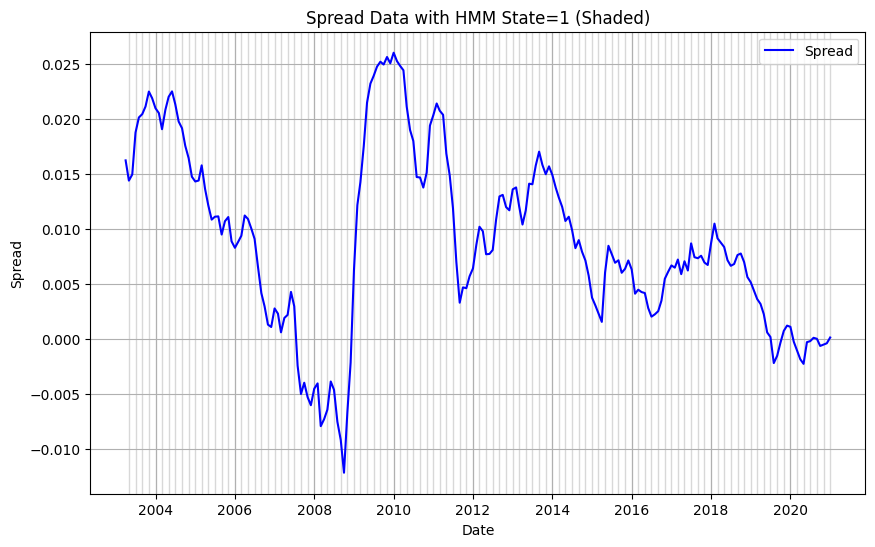

In [ ]:
spreadShortLongRates["YEAR_MONTH"] = pd.to_datetime(spreadShortLongRates["YEAR_MONTH"])

spreadShortLongRates_data = spreadShortLongRates["spread"].values

model_spread = hmm.GaussianHMM(n_components=2, n_iter=1000)
X = spreadShortLongRates_data.reshape(-1, 1)  
model_spread.fit(X)

pred_states = model_spread.predict(X)

def contiguous_regions(condition):
    """
    Returns a list of (start, end) indices for each contiguous True
    block in a boolean array 'condition'.
    """
    diff = np.diff(condition)
    idx, = diff.nonzero()
    idx += 1

    if condition[0]:
        idx = np.r_[0, idx]

    if condition[-1]:
        idx = np.r_[idx, condition.size]

    idx = idx.reshape((-1, 2))
    return idx

mask_state_1 = (pred_states == 1)
regions_state_1 = contiguous_regions(mask_state_1)

fig, ax = plt.subplots(figsize=(10, 6))

dates = spreadShortLongRates["YEAR_MONTH"]

ax.plot(dates, spreadShortLongRates_data, label="Spread", color='blue')

for start_idx, end_idx in regions_state_1:
    ax.axvspan(dates.iloc[start_idx], dates.iloc[end_idx - 1],
               color='gray', alpha=0.3)

ax.set_title("Spread Data with HMM State=1 (Shaded)")
ax.set_xlabel("Date")
ax.set_ylabel("Spread")
ax.legend()
ax.grid(True)

plt.show()

In [ ]:
data_state0 = spreadShortLongRates_data[pred_states == 0]
data_state1 = spreadShortLongRates_data[pred_states == 1]

vasicek_0 = Vasicek(dt)
a0, mu0, sigma0, _0 = vasicek_0.calibrate_ols(data_state0)

vasicek_1 = Vasicek(dt)
a1, mu1, sigma1, _1 = vasicek_1.calibrate_ols(data_state1)

print("Regime 0 Vasicek params (stable state):")
print(f'Speed of mean reversion: {np.round(a0, 2)} %')
print(f'Long term mean: {np.round(mu0, 2)} %')
print(f'Sigma: {np.round(sigma0, 2)} %')
print(f'Probablity of state 1 to 2: {np.round(model_lt.transmat_[0:1,1] * 100, 2)} %')
print(f'R-Squared Adjusted: {np.round(_0.rsquared_adj * 100, 2)} %')


print("\nRegime 1 Vasicek params (crisis state):")
print(f'Speed of mean reversion: {np.round(a1, 2)} %')
print(f'Long term mean: {np.round(mu1, 2)} %')
print(f'Sigma: {np.round(sigma1, 2)} %')
print(f'Probablity of state 2 to 1: {np.round(model_lt.transmat_[1:,0] * 100, 2)} %')
print(f'R-Squared Adjusted: {np.round(_1.rsquared_adj * 100, 2)} %')

Regime 0 Vasicek params (stable state):
Speed of mean reversion: 0.85 %
Long term mean: 0.01 %
Sigma: 0.01 %
Probablity of state 1 to 2: [0.98] %
R-Squared Adjusted: 86.31 %

Regime 1 Vasicek params (crisis state):
Speed of mean reversion: 0.75 %
Long term mean: 0.01 %
Sigma: 0.01 %
Probablity of state 2 to 1: [0.] %
R-Squared Adjusted: 87.58 %


## Equity

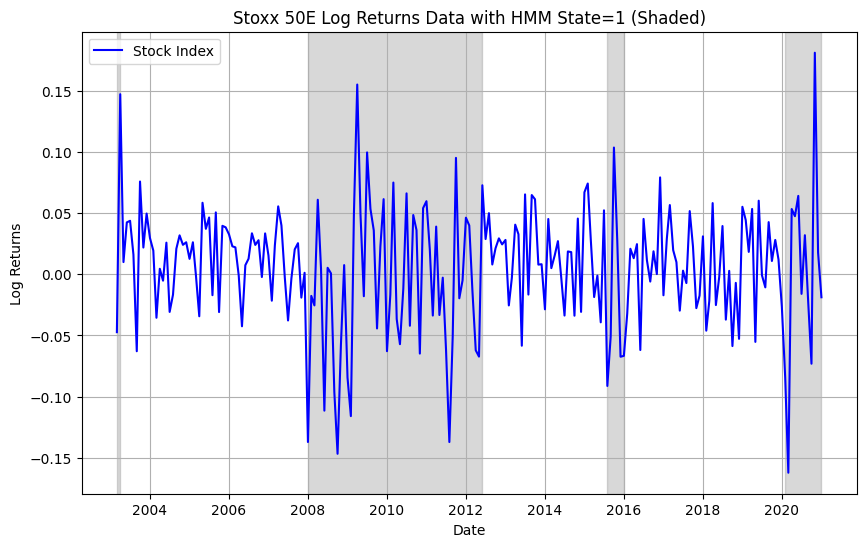

In [ ]:
stoxx50E["YEAR_MONTH"] = pd.to_datetime(stoxx50E["YEAR_MONTH"])

stoxx50E_data = stoxx50E["log_returns"].values

model_equity = hmm.GaussianHMM(n_components=2, n_iter=1000)
X = stoxx50E_data.reshape(-1, 1)  
model_equity.fit(X)

pred_states = model_equity.predict(X)
stoxx50E["stocks_state"] = pred_states

def contiguous_regions(condition):
    """
    Returns a list of (start, end) indices for each contiguous True
    block in a boolean array 'condition'.
    """
    diff = np.diff(condition)
    idx, = diff.nonzero()
    idx += 1

    if condition[0]:
        idx = np.r_[0, idx]

    if condition[-1]:
        idx = np.r_[idx, condition.size]

    idx = idx.reshape((-1, 2))
    return idx

mask_state_1 = (pred_states == 1)
regions_state_1 = contiguous_regions(mask_state_1)

fig, ax = plt.subplots(figsize=(10, 6))

dates = stoxx50E["YEAR_MONTH"]

ax.plot(dates, stoxx50E_data, label="Stock Index", color='blue')

for start_idx, end_idx in regions_state_1:
    ax.axvspan(dates.iloc[start_idx], dates.iloc[end_idx - 1],
               color='gray', alpha=0.3)

ax.set_title("Stoxx 50E Log Returns Data with HMM State=1 (Shaded)")
ax.set_xlabel("Date")
ax.set_ylabel("Log Returns")
ax.legend()
ax.grid(True)

plt.show()

In [ ]:
data_state0 = stoxx50E_data[pred_states == 0]
data_state1 = stoxx50E_data[pred_states == 1]

mean_0 = data_state0.mean()
mean_1 = data_state1.mean()

residuals_stock0 = data_state0 - mean_0
residuals_stock1 = data_state1 - mean_1

black_scholes_stocks0 = BlackScholes(dt)
mu_stock0, sigma_stock0 = black_scholes_stocks0.calibrate(data_state0)

black_scholes_stocks1 = BlackScholes(dt)
mu_stock1, sigma_stock1 = black_scholes_stocks1.calibrate(data_state1)

print("Regime 0 GBM params (stable state):")
print(f"Drift (mu)     = {mu_stock0:.4%}")
print(f"Volatility (σ) = {sigma_stock0:.4%}")
print(f'Probablity of state 1 to 2: {np.round(model_equity.transmat_[0:1,1] * 100, 2)} %')

print("\nRegime 1 GBM params (crisis state):")
print(f"Drift (mu)     = {mu_stock1:.4%}")
print(f"Volatility (σ) = {sigma_stock1:.4%}")
print(f'Probablity of state 2 to 1: {np.round(model_equity.transmat_[1:,0] * 100, 2)} %')

Regime 0 GBM params (stable state):
Drift (mu)     = 1.1833%
Volatility (σ) = 3.2282%
Probablity of state 1 to 2: [3.83] %

Regime 1 GBM params (crisis state):
Drift (mu)     = -0.5502%
Volatility (σ) = 7.0449%
Probablity of state 2 to 1: [7.98] %


Normality of residuals

In [ ]:
# Shapiro Test of Normality

shapiro_test = stats.shapiro(residuals_stock0)
shapiro_test

ShapiroResult(statistic=0.9812658169616515, pvalue=0.0503724242163277)

In [ ]:
# Shapiro Test of Normality

shapiro_test = stats.shapiro(residuals_stock1)
shapiro_test

ShapiroResult(statistic=0.9884690858476953, pvalue=0.7419194278587327)

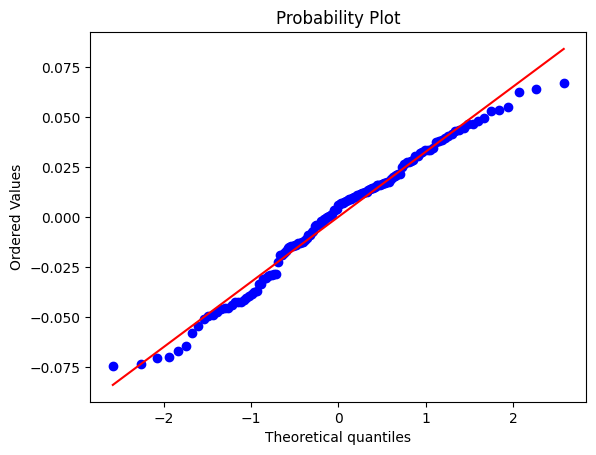

In [ ]:
## QQ-Plot against normal distribution

stats.probplot(residuals_stock0, dist='norm', plot=plt)
plt.show()

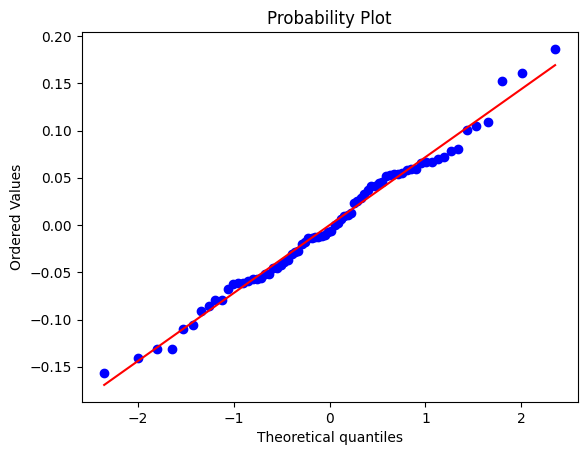

In [ ]:
## QQ-Plot against normal distribution

stats.probplot(residuals_stock1, dist='norm', plot=plt)
plt.show()

In [ ]:
stoxx50E["stocks_resid_0"] = np.nan
stoxx50E["stocks_resid_1"] = np.nan

idx_0 = stoxx50E.index[stoxx50E["stocks_state"] == 0]
idx_1 = stoxx50E.index[stoxx50E["stocks_state"] == 1]

stoxx50E.loc[idx_0, "stocks_resid_0"] = residuals_stock0
stoxx50E.loc[idx_1, "stocks_resid_1"] = residuals_stock1

## Real Estate

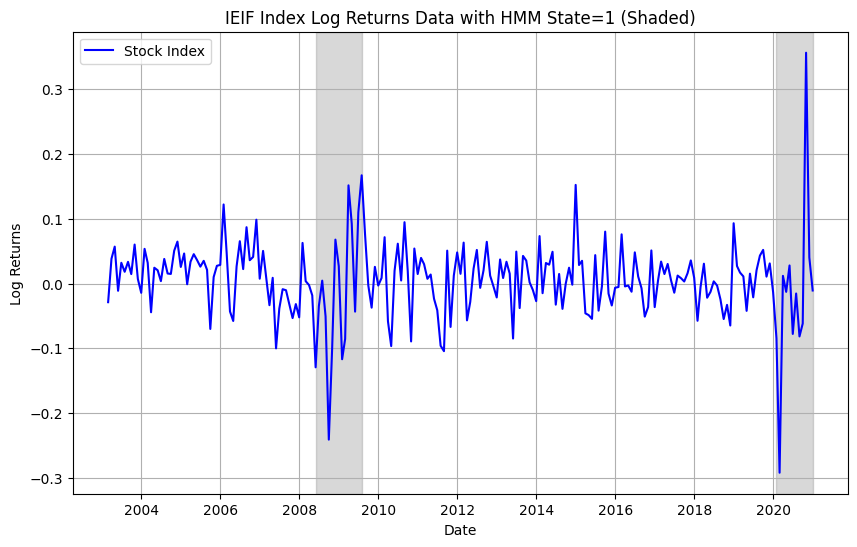

In [ ]:
IEIFIndex["YEAR_MONTH"] = pd.to_datetime(IEIFIndex["YEAR_MONTH"])

IEIFIndex_data = IEIFIndex["log_returns"].values

model_re = hmm.GaussianHMM(n_components=2, n_iter=1000)
X = IEIFIndex_data.reshape(-1, 1)  
model_re.fit(X)

pred_states = model_re.predict(X)

def contiguous_regions(condition):
    """
    Returns a list of (start, end) indices for each contiguous True
    block in a boolean array 'condition'.
    """
    diff = np.diff(condition)
    idx, = diff.nonzero()
    idx += 1

    if condition[0]:
        idx = np.r_[0, idx]

    if condition[-1]:
        idx = np.r_[idx, condition.size]

    idx = idx.reshape((-1, 2))
    return idx

mask_state_1 = (pred_states == 1)
regions_state_1 = contiguous_regions(mask_state_1)

fig, ax = plt.subplots(figsize=(10, 6))

dates = IEIFIndex["YEAR_MONTH"]

ax.plot(dates, IEIFIndex_data, label="Stock Index", color='blue')

for start_idx, end_idx in regions_state_1:
    ax.axvspan(dates.iloc[start_idx], dates.iloc[end_idx - 1],
               color='gray', alpha=0.3)

ax.set_title("IEIF Index Log Returns Data with HMM State=1 (Shaded)")
ax.set_xlabel("Date")
ax.set_ylabel("Log Returns")
ax.legend()
ax.grid(True)

plt.show()

In [ ]:
data_state0 = IEIFIndex_data[pred_states == 0]
data_state1 = IEIFIndex_data[pred_states == 1]

black_scholes_re0 = BlackScholes(dt)
mu_re0, sigma_re0 = black_scholes_re0.calibrate(data_state0)

black_scholes_re1 = BlackScholes(dt)
mu_re1, sigma_re1 = black_scholes_re1.calibrate(data_state1)

print("Regime 0 GBM params (stable state):")
print(f"Drift (mu)     = {mu_re0:.4%}")
print(f"Volatility (σ) = {sigma_re0:.4%}")
print(f'Probablity of state 1 to 2: {np.round(model_re.transmat_[0:1,1] * 100, 2)} %')

print("\nRegime 1 GBM params (crisis state):")
print(f"Drift (mu)     = {mu_re1:.4%}")
print(f"Volatility (σ) = {sigma_re1:.4%}")
print(f'Probablity of state 2 to 1: {np.round(model_re.transmat_[1:,0] * 100, 2)} %')

Regime 0 GBM params (stable state):
Drift (mu)     = 0.8480%
Volatility (σ) = 4.2312%
Probablity of state 1 to 2: [2.07] %

Regime 1 GBM params (crisis state):
Drift (mu)     = -1.4120%
Volatility (σ) = 12.5079%
Probablity of state 2 to 1: [12.1] %


In [ ]:
residuals_re0 = IEIFIndex['log_returns'].values - mu_re0
residuals_re1 = IEIFIndex['log_returns'].values - mu_re1

In [ ]:
# Shapiro Test of Normality

shapiro_test = stats.shapiro(residuals_re0)
shapiro_test

ShapiroResult(statistic=0.8968155788979674, pvalue=5.269104347370423e-11)

In [ ]:
# Shapiro Test of Normality

shapiro_test = stats.shapiro(residuals_re1)
shapiro_test

ShapiroResult(statistic=0.8968155788979674, pvalue=5.269104347370423e-11)

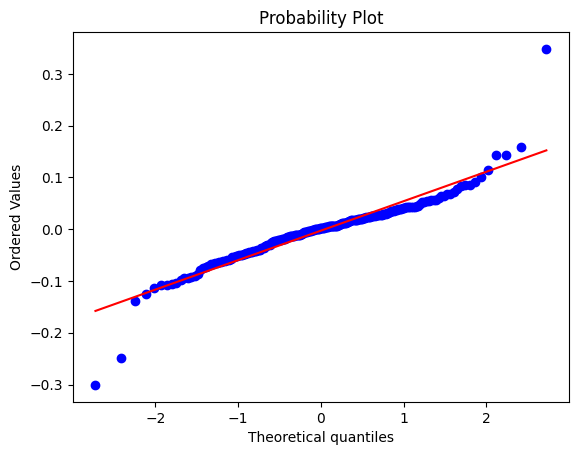

In [ ]:
## QQ-Plot against normal distribution

stats.probplot(residuals_re0, dist='norm', plot=plt)
plt.show()

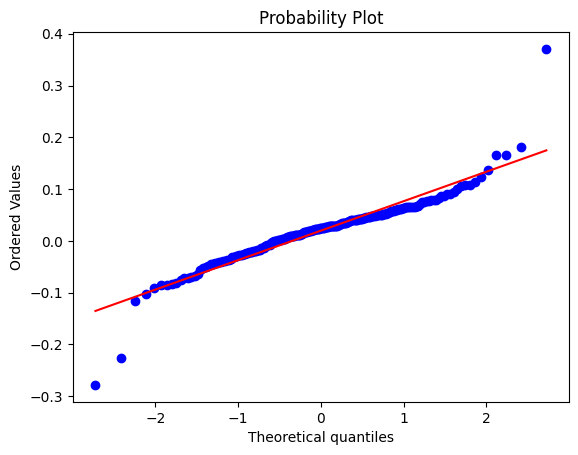

In [ ]:
## QQ-Plot against normal distribution

stats.probplot(residuals_re1, dist='norm', plot=plt)
plt.show()

Markov Estimation in Dimension 2

We have seen that Stoxx 50E index and IEIF Index were highly correlated. This would suggest that Markov Chains generating financial cycles of equity and real estate are highly correlated together.

We will then consider a Markov Chain shared by the two assets.

In [ ]:
X = np.column_stack([stoxx50E_data, IEIFIndex_data])

model = hmm.GaussianHMM(
    n_components=2,
    covariance_type='full',  
    n_iter=1000
)

model.fit(X) 
hidden_states = model.predict(X)

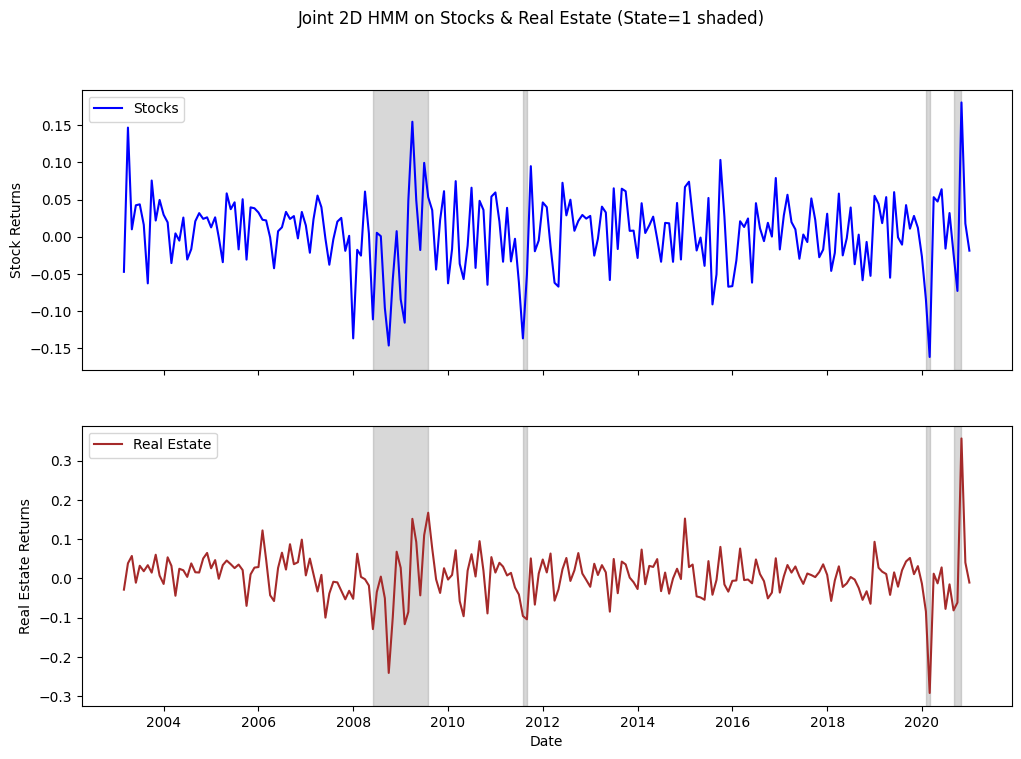

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

axes[0].plot(dates, stoxx50E_data, color='blue', label='Stocks')
axes[0].set_ylabel("Stock Returns")

axes[1].plot(dates, IEIFIndex_data, color='brown', label='Real Estate')
axes[1].set_ylabel("Real Estate Returns")
axes[1].set_xlabel("Date")

mask_state_1 = (hidden_states == 1)
regions_state_1 = contiguous_regions(mask_state_1)

for start_idx, end_idx in regions_state_1:
    axes[0].axvspan(dates[start_idx], dates[end_idx - 1],
                    color='gray', alpha=0.3)
    axes[1].axvspan(dates[start_idx], dates[end_idx - 1],
                    color='gray', alpha=0.3)

axes[0].legend(loc='best')
axes[1].legend(loc='best')
plt.suptitle("Joint 2D HMM on Stocks & Real Estate (State=1 shaded)")
plt.show()

In [ ]:
bs_stock_0 = BlackScholes(dt)
bs_stock_1 = BlackScholes(dt)

bs_re_0 = BlackScholes(dt)
bs_re_1 = BlackScholes(dt)

stock_state0 = X[hidden_states == 0, 0]  
stock_state1 = X[hidden_states == 1, 0]

re_state0 = X[hidden_states == 0, 1]     
re_state1 = X[hidden_states == 1, 1]

mu_s0_0, sig_s0_0 = bs_stock_0.calibrate(stock_state0)   
mu_s0_1, sig_s0_1 = bs_stock_1.calibrate(stock_state1)   

mu_re_0, sig_re_0 = bs_re_0.calibrate(re_state0)         
mu_re_1, sig_re_1 = bs_re_1.calibrate(re_state1) 

In [ ]:
print("Stocks\n")

print("Regime 0 GBM params (stable state):")
print(f"Drift (mu)     = {mu_s0_0:.4f}")
print(f"Volatility (σ) = {sig_s0_0:.4%}")
print(f'Probablity of state 1 to 2: {np.round(model.transmat_[0:1,1] * 100, 2)} %')

print("\nRegime 1 GBM params (crisis state):")
print(f"Drift (mu)     = {mu_s0_1:.4%}")
print(f"Volatility (σ) = {sig_s0_1:.4%}")
print(f'Probablity of state 2 to 1: {np.round(model.transmat_[1:,0] * 100, 2)} %')

print("\nReal Estate\n")

print("Regime 0 GBM params (stable state):")
print(f"Drift (mu)     = {mu_re_0:.4%}")
print(f"Volatility (σ) = {sig_re_0:.4%}")
print(f'Probablity of state 1 to 2: {np.round(model.transmat_[0:1,1] * 100, 2)} %')

print("\nRegime 1 GBM params (crisis state):")
print(f"Drift (mu)     = {mu_re_1:.4%}")
print(f"Volatility (σ) = {sig_re_1:.4%}")
print(f'Probablity of state 2 to 1: {np.round(model.transmat_[1:,0] * 100, 2)} %')

Stocks

Regime 0 GBM params (stable state):
Drift (mu)     = 0.0094
Volatility (σ) = 4.0505%
Probablity of state 1 to 2: [3.75] %

Regime 1 GBM params (crisis state):
Drift (mu)     = -2.5520%
Volatility (σ) = 9.2441%
Probablity of state 2 to 1: [24.05] %

Real Estate

Regime 0 GBM params (stable state):
Drift (mu)     = 0.9109%
Volatility (σ) = 4.0912%
Probablity of state 1 to 2: [3.75] %

Regime 1 GBM params (crisis state):
Drift (mu)     = -2.4776%
Volatility (σ) = 13.9042%
Probablity of state 2 to 1: [24.05] %


Dependance Structure

In [ ]:
df_merged = (
    inflationEuro[["YEAR_MONTH","inflation_state","inflation_resid_0","inflation_resid_1"]]
    .merge(stoxx50E[["YEAR_MONTH","stocks_state","stocks_resid_0","stocks_resid_1"]],
           on="YEAR_MONTH", how="inner")
    .merge(bund10Years[["YEAR_MONTH","bund_resid"]], on="YEAR_MONTH", how="inner")
    .merge(spreadShortLongRates[["YEAR_MONTH","spread_resid"]], on="YEAR_MONTH", how="inner")
    .merge(IEIFIndex[["YEAR_MONTH","re_resid"]], on="YEAR_MONTH", how="inner")
)

In [ ]:
df_00 = df_merged[
    (df_merged["inflation_state"] == 0) &
    (df_merged["stocks_state"] == 0)
]

corr_00 = df_00[[
    "inflation_resid_0",
    "stocks_resid_0",
    "bund_resid",
    "spread_resid",
    "re_resid"
]].corr()

df_01 = df_merged[
    (df_merged["inflation_state"] == 0) &
    (df_merged["stocks_state"] == 1)
]
corr_01 = df_01[[
    "inflation_resid_0",
    "stocks_resid_1",
    "bund_resid",
    "spread_resid",
    "re_resid"
]].corr()

df_10 = df_merged[
    (df_merged["inflation_state"] == 1) &
    (df_merged["stocks_state"] == 0)
]
corr_10 = df_10[[
    "inflation_resid_1",
    "stocks_resid_0",
    "bund_resid",
    "spread_resid",
    "re_resid"
]].corr()

df_11 = df_merged[
    (df_merged["inflation_state"] == 1) &
    (df_merged["stocks_state"] == 1)
]
corr_11 = df_11[[
    "inflation_resid_1",
    "stocks_resid_1",
    "bund_resid",
    "spread_resid",
    "re_resid"
]].corr()

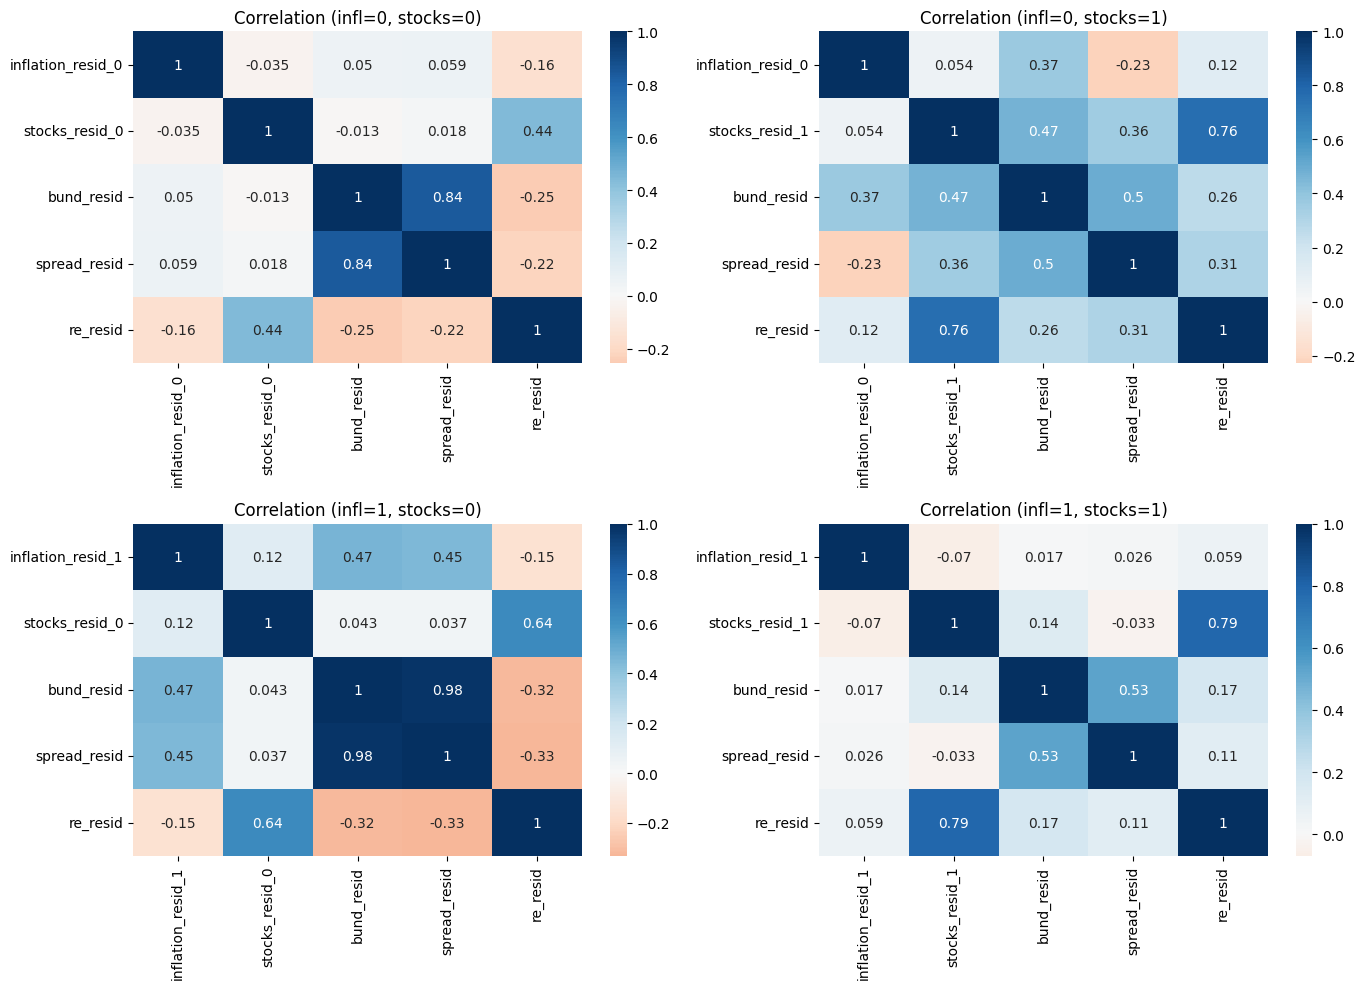

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

sns.heatmap(corr_00, annot=True, cmap="RdBu", center=0, ax=axes[0,0])
axes[0,0].set_title("Correlation (infl=0, stocks=0)")

sns.heatmap(corr_01, annot=True, cmap="RdBu", center=0, ax=axes[0,1])
axes[0,1].set_title("Correlation (infl=0, stocks=1)")

sns.heatmap(corr_10, annot=True, cmap="RdBu", center=0, ax=axes[1,0])
axes[1,0].set_title("Correlation (infl=1, stocks=0)")

sns.heatmap(corr_11, annot=True, cmap="RdBu", center=0, ax=axes[1,1])
axes[1,1].set_title("Correlation (infl=1, stocks=1)")

plt.tight_layout()
plt.show()

Projections

Check : 

- Uses of T and dt
- Re-check the structure of the models
- Re-check which model uses Markov Chain
- Check calibration for Black & Scholes Model : there is a problem with mu and sigma

In [ ]:
class MarkovChainGSE:
    """
    Example: Markov-switching scenario generator for inflation & equity (2 states each).
    Other assets remain single-regime.
    """

    def __init__(
        self,
        dt,
        vasicek_infl_0,  
        vasicek_infl_1,
        transmat_infl,   

        bs_equity_0,     
        bs_equity_1,
        transmat_equity, 

        vasicek_interest=None,
        vasicek_spread=None,
        bs_realestate=None,

        corr_matrix=None
    ):
        self.dt = dt

        self.vasicek_infl_0 = vasicek_infl_0
        self.vasicek_infl_1 = vasicek_infl_1
        self.P_infl = transmat_infl  

        self.bs_equity_0 = bs_equity_0
        self.bs_equity_1 = bs_equity_1
        self.P_equity = transmat_equity

        self.vasicek_interest = vasicek_interest
        self.vasicek_spread = vasicek_spread
        self.bs_re = bs_realestate

        self.corr_matrix = corr_matrix
        if corr_matrix is not None:
            self.cholesky = np.linalg.cholesky(corr_matrix)
        else:
            self.cholesky = None

    def _simulate_markov_chain(self, P, n_scenarios, num_steps, init_state=0):
        """
        Simple helper to simulate a 2-state Markov chain with transition matrix P.
        Return states: shape (n_scenarios, num_steps+1).
        """
        states = np.zeros((n_scenarios, num_steps+1), dtype=int)
        states[:, 0] = init_state
        for s in range(n_scenarios):
            for t in range(num_steps):
                current = states[s, t]
                next_state = np.random.choice([0,1], p=P[current])
                states[s, t+1] = next_state
        return states

    def simulate_scenarios_with_states(
            self,
            n_scenarios=1000,
            num_steps=10,
            infl_init=0.02,
            equity_init=100.0,
            interest_init=0.01,
            spread_init=0.01,
            re_init=100.0,
            init_state_infl=0,
            init_state_equity=0
    ):
        """
        Simulate paths using Markov switching for inflation + equity.
        Others remain single-regime.
        """
        dt = self.dt
        infl_states = self._simulate_markov_chain(self.P_infl, n_scenarios, num_steps, init_state_infl)
        eq_states   = self._simulate_markov_chain(self.P_equity, n_scenarios, num_steps, init_state_equity)

        infl_paths = np.zeros((num_steps+1, n_scenarios))
        eq_paths   = np.zeros((num_steps+1, n_scenarios))
        interest_paths = np.zeros((num_steps+1, n_scenarios))
        spread_paths   = np.zeros((num_steps+1, n_scenarios))
        re_paths       = np.zeros((num_steps+1, n_scenarios))

        infl_paths[0,:] = infl_init
        eq_paths[0,:]   = equity_init
        interest_paths[0,:] = interest_init
        spread_paths[0,:]   = spread_init
        re_paths[0,:]       = re_init

        for t in range(1, num_steps+1):
            Z = np.random.normal(0, 1, size=(5, n_scenarios))
            if self.cholesky is not None:
                Z = self.cholesky @ Z

            eps_infl = Z[0,:]
            eps_int  = Z[1,:]
            eps_spread = Z[2,:]
            eps_eq   = Z[3,:]
            eps_re   = Z[4,:]

            old_infl = infl_paths[t-1,:]
            old_eq   = eq_paths[t-1,:]
            old_int  = interest_paths[t-1,:]
            old_sp   = spread_paths[t-1,:]
            old_re   = re_paths[t-1,:]

            for s in range(n_scenarios):
                st_infl = infl_states[s, t-1]
                if st_infl == 0:
                    a_i = self.vasicek_infl_0.a
                    mu_i = self.vasicek_infl_0.mu
                    sigma_i = self.vasicek_infl_0.sigma
                else:
                    a_i = self.vasicek_infl_1.a
                    mu_i = self.vasicek_infl_1.mu
                    sigma_i = self.vasicek_infl_1.sigma

                st_eq = eq_states[s, t-1]
                if st_eq == 0:
                    mu_eq = self.bs_equity_0.mu
                    sig_eq = self.bs_equity_0.sigma
                else:
                    mu_eq = self.bs_equity_1.mu
                    sig_eq = self.bs_equity_1.sigma

                exp_term = np.exp(-a_i*dt)
                drift = mu_i*(1 - exp_term)
                vol   = sigma_i*np.sqrt((1 - np.exp(-2*a_i*dt)) / (2*a_i))
                new_infl = drift + exp_term*old_infl[s] + vol*eps_infl[s]

                drift_eq = (mu_eq - 0.5*sig_eq**2)*dt
                diff_eq  = sig_eq*np.sqrt(dt)*eps_eq[s]
                new_eq = old_eq[s]*np.exp(drift_eq + diff_eq)

                if self.vasicek_interest is not None:
                    a_l = self.vasicek_interest.a
                    mu_l= self.vasicek_interest.mu
                    sigma_l= self.vasicek_interest.sigma
                    exp_l = np.exp(-a_l*dt)
                    drift_l = mu_l*(1-exp_l)
                    vol_l   = sigma_l*np.sqrt((1-np.exp(-2*a_l*dt))/(2*a_l))
                    new_int = drift_l + exp_l*old_int[s] + vol_l*eps_int[s]
                else:
                    new_int = old_int[s]

                if self.vasicek_spread is not None:
                    a_sp = self.vasicek_spread.a
                    mu_sp= self.vasicek_spread.mu
                    sigma_sp= self.vasicek_spread.sigma
                    exp_sp = np.exp(-a_sp*dt)
                    drift_sp = mu_sp*(1-exp_sp)
                    vol_sp   = sigma_sp*np.sqrt((1-np.exp(-2*a_sp*dt))/(2*a_sp))
                    new_spread = drift_sp + exp_sp*old_sp[s] + vol_sp*eps_spread[s]
                else:
                    new_spread = old_sp[s]

                if self.bs_re is not None:
                    mu_re = self.bs_re.mu
                    sig_re= self.bs_re.sigma
                    drift_re = (mu_re - 0.5*sig_re**2)*dt
                    diff_re  = sig_re*np.sqrt(dt)*eps_re[s]
                    new_re = old_re[s]*np.exp(drift_re + diff_re)
                else:
                    new_re = old_re[s]

                infl_paths[t,s] = new_infl
                eq_paths[t,s]   = new_eq
                interest_paths[t,s] = new_int
                spread_paths[t,s]   = new_spread
                re_paths[t,s]       = new_re

        return {
            'inflation' : infl_paths,
            'equity'    : eq_paths,
            'interest'  : interest_paths,
            'spread'    : spread_paths,
            'realestate': re_paths
        }


    def simulate_scenarios_no_states(
            self,
            n_scenarios=1000,
            num_steps=10,
            infl_init=0.02,
            equity_init=100.0,
            interest_init=0.01,
            spread_init=0.01,
            re_init=100.0
    ):
        """
        Simulate paths with *no* Markov switching, e.g. single-regime parameters
        for inflation & equity. We can pick 'state 0' or average them, etc.
        """
        a_i = self.vasicek_infl_0.a
        mu_i= self.vasicek_infl_0.mu
        sigma_i=self.vasicek_infl_0.sigma

        mu_eq= self.bs_equity_0.mu
        sig_eq=self.bs_equity_0.sigma

        dt = self.dt

        infl_paths = np.zeros((num_steps+1, n_scenarios))
        eq_paths   = np.zeros((num_steps+1, n_scenarios))
        interest_paths = np.zeros((num_steps+1, n_scenarios))
        spread_paths   = np.zeros((num_steps+1, n_scenarios))
        re_paths       = np.zeros((num_steps+1, n_scenarios))

        infl_paths[0,:]= infl_init
        eq_paths[0,:]  = equity_init
        interest_paths[0,:]= interest_init
        spread_paths[0,:]  = spread_init
        re_paths[0,:]      = re_init

        for t in range(1, num_steps+1):
            Z = np.random.normal(0, 1, (5, n_scenarios))
            if self.cholesky is not None:
                Z = self.cholesky @ Z

            eps_infl= Z[0,:]
            eps_int = Z[1,:]
            eps_sp  = Z[2,:]
            eps_eq  = Z[3,:]
            eps_re  = Z[4,:]

            old_infl= infl_paths[t-1,:]
            old_eq  = eq_paths[t-1,:]
            old_int = interest_paths[t-1,:]
            old_sp  = spread_paths[t-1,:]
            old_re  = re_paths[t-1,:]

            exp_i = np.exp(-a_i*dt)
            drift_i = mu_i*(1 - exp_i)
            vol_i   = sigma_i*np.sqrt((1 - np.exp(-2*a_i*dt))/(2*a_i))
            new_infl= drift_i + exp_i*old_infl + vol_i*eps_infl

            drift_eq= (mu_eq - 0.5*sig_eq**2)*dt
            diff_eq = sig_eq*np.sqrt(dt)*eps_eq
            new_eq  = old_eq*np.exp(drift_eq + diff_eq)

            if self.vasicek_interest is not None:
                a_l= self.vasicek_interest.a
                mu_l=self.vasicek_interest.mu
                sigma_l=self.vasicek_interest.sigma
                exp_l=np.exp(-a_l*dt)
                drift_l= mu_l*(1 - exp_l)
                vol_l  = sigma_l*np.sqrt((1-np.exp(-2*a_l*dt))/(2*a_l))
                new_int= drift_l + exp_l*old_int + vol_l*eps_int
            else:
                new_int= old_int

            if self.vasicek_spread is not None:
                a_sp= self.vasicek_spread.a
                mu_sp=self.vasicek_spread.mu
                sigma_sp=self.vasicek_spread.sigma
                exp_sp= np.exp(-a_sp*dt)
                drift_sp= mu_sp*(1 - exp_sp)
                vol_sp= sigma_sp*np.sqrt((1-np.exp(-2*a_sp*dt))/(2*a_sp))
                new_sp= drift_sp + exp_sp*old_sp + vol_sp*eps_sp
            else:
                new_sp= old_sp

            if self.bs_re is not None:
                m_re= self.bs_re.mu
                s_re= self.bs_re.sigma
                drift_re= (m_re - 0.5*s_re**2)*dt
                diff_re=  s_re*np.sqrt(dt)*eps_re
                new_re= old_re*np.exp(drift_re + diff_re)
            else:
                new_re= old_re

            infl_paths[t,:] = new_infl
            eq_paths[t,:]   = new_eq
            interest_paths[t,:] = new_int
            spread_paths[t,:]   = new_sp
            re_paths[t,:]       = new_re

        return {
            'inflation': infl_paths,
            'equity': eq_paths,
            'interest': interest_paths,
            'spread': spread_paths,
            'realestate': re_paths
        }

    def plot_5_95_comparison(self, results_with, results_no, variable, title=None):
        """
        Plot 5% & 95% quantiles for 'variable' from two scenario sets:
          - results_with: Markov-switching
          - results_no: single-regime
        Overlaid on the same chart.
        """
        data_with = results_with[variable]   
        data_no   = results_no[variable]

        q5_with = np.quantile(data_with, 0.05, axis=1)
        q95_with= np.quantile(data_with, 0.95, axis=1)

        q5_no = np.quantile(data_no, 0.05, axis=1)
        q95_no= np.quantile(data_no, 0.95, axis=1)

        steps = data_with.shape[0]
        time = np.arange(steps)*self.dt

        plt.figure(figsize=(10,6))
        plt.fill_between(time, q5_with, q95_with, color='blue', alpha=0.2, label='With States (5%-95%)')
        plt.fill_between(time, q5_no, q95_no, color='red', alpha=0.2, label='No States (5%-95%)')

        plt.xlabel("Time (years)")
        plt.ylabel(variable)
        plt.legend()
        if title is None:
            title = f"Comparison: {variable} (States vs No States)"
        plt.title(title)
        plt.grid(True)
        plt.show()

In [ ]:
# Inflation

inflationEuro["YEAR_MONTH"] = pd.to_datetime(inflationEuro["YEAR_MONTH"])

inflationEuro_data = inflationEuro["inflation"].values

model_inflation = hmm.GaussianHMM(n_components=2, n_iter=100)
X = inflationEuro_data.reshape(-1, 1)  
model_inflation.fit(X)

pred_states = model_inflation.predict(X)
inflationEuro['inflation_state'] = pred_states

data_state0 = inflationEuro_data[pred_states == 0]
data_state1 = inflationEuro_data[pred_states == 1]

idx_0 = inflationEuro.index[inflationEuro["inflation_state"] == 0]
idx_0_aligned = idx_0[:-1]
r0 = inflationEuro.loc[idx_0_aligned, "inflation"].values

idx_1 = inflationEuro.index[inflationEuro["inflation_state"] == 1]
idx_1_aligned = idx_1[:-1]
r1 = inflationEuro.loc[idx_1_aligned, "inflation"].values

vasicek_0 = Vasicek(dt)
a0, mu0, sigma0, _0 = vasicek_0.calibrate_ols(r0)

vasicek_1 = Vasicek(dt)
a1, mu1, sigma1, _1 = vasicek_1.calibrate_ols(r1)

P_infl = model_inflation.transmat_

NameError: name 'pd' is not defined

In [ ]:
# Equity

stoxx50E["YEAR_MONTH"] = pd.to_datetime(stoxx50E["YEAR_MONTH"])

stoxx50E_data = stoxx50E["log_returns"].values

model_equity = hmm.GaussianHMM(n_components=2, n_iter=1000)
X = stoxx50E_data.reshape(-1, 1)  
model_equity.fit(X)

pred_states = model_equity.predict(X)
stoxx50E["stocks_state"] = pred_states

data_state0 = stoxx50E_data[pred_states == 0]
data_state1 = stoxx50E_data[pred_states == 1]

mean_0 = data_state0.mean()
mean_1 = data_state1.mean()

residuals_stock0 = data_state0 - mean_0
residuals_stock1 = data_state1 - mean_1 

black_scholes_stocks0 = BlackScholes(dt)
mu_stock0, sigma_stock0 = black_scholes_stocks0.calibrate(data_state0)

black_scholes_stocks1 = BlackScholes(dt)
mu_stock1, sigma_stock1 = black_scholes_stocks1.calibrate(data_state1)

P_equity = model_equity.transmat_

In [ ]:
# Long Term Rates
vasicek_long = Vasicek(dt)
a_long, mu_long, sigma_long, results_long = vasicek_long.calibrate_ols(bund_10_years_data)

# Spread
vasicek_sprd = Vasicek(dt)
a_spread, mu_spread, sigma_spread, results_spread = vasicek_sprd.calibrate_ols(spreadShortLongRates_data)

# Real Estate
bs_re = BlackScholes(dt)
mu_re, sigma_re = bs_re.calibrate(IEIFIndex_data)

In [ ]:
corr = corr_matrix

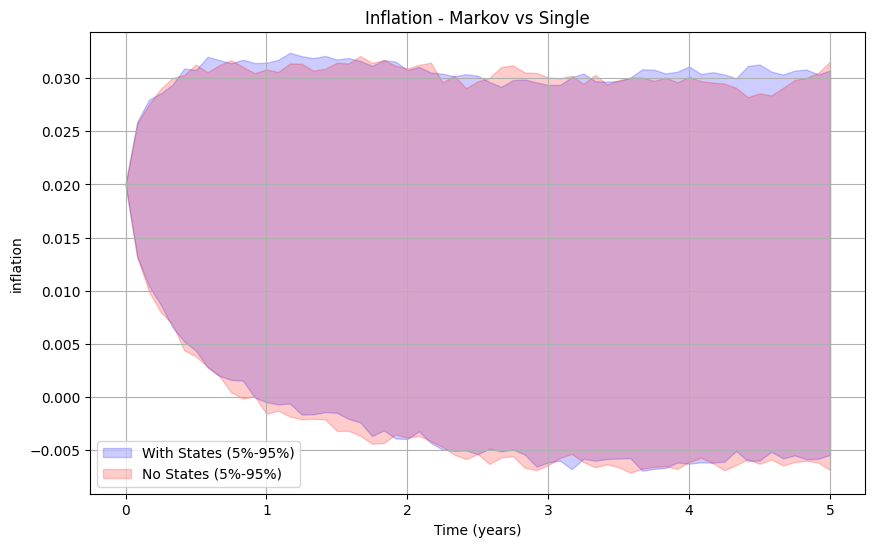

In [ ]:
gse = MarkovChainGSE(
    dt=dt,
    vasicek_infl_0=vasicek_0, vasicek_infl_1=vasicek_1, transmat_infl=P_infl,
    bs_equity_0=black_scholes_stocks0, bs_equity_1=black_scholes_stocks1, transmat_equity=P_equity,
    vasicek_interest=vasicek_long, vasicek_spread=vasicek_sprd, bs_realestate=bs_re,
    corr_matrix=corr
)

results_with  = gse.simulate_scenarios_with_states(n_scenarios=1000, num_steps=60)
results_no    = gse.simulate_scenarios_no_states(n_scenarios=1000, num_steps=60)

gse.plot_5_95_comparison(results_with, results_no, variable='inflation', title="Inflation - Markov vs Single")

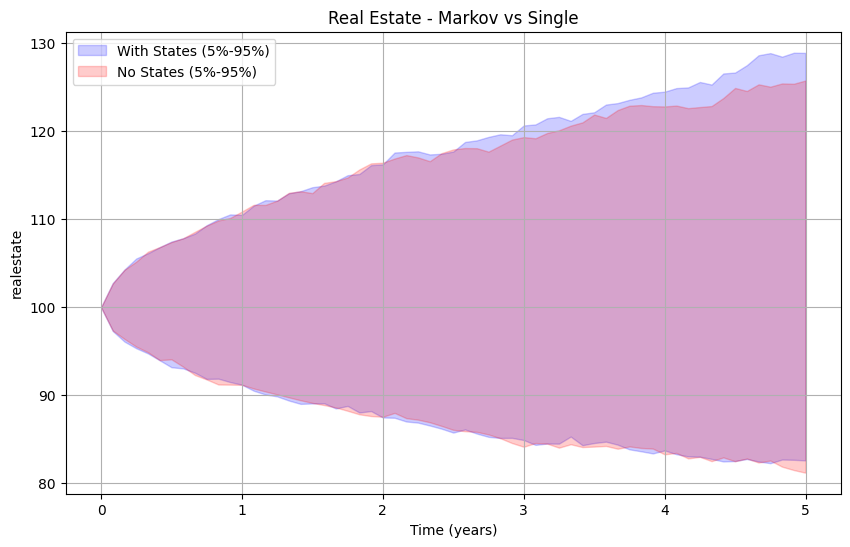

In [ ]:
gse.plot_5_95_comparison(results_with, results_no, variable='realestate', title="Real Estate - Markov vs Single")

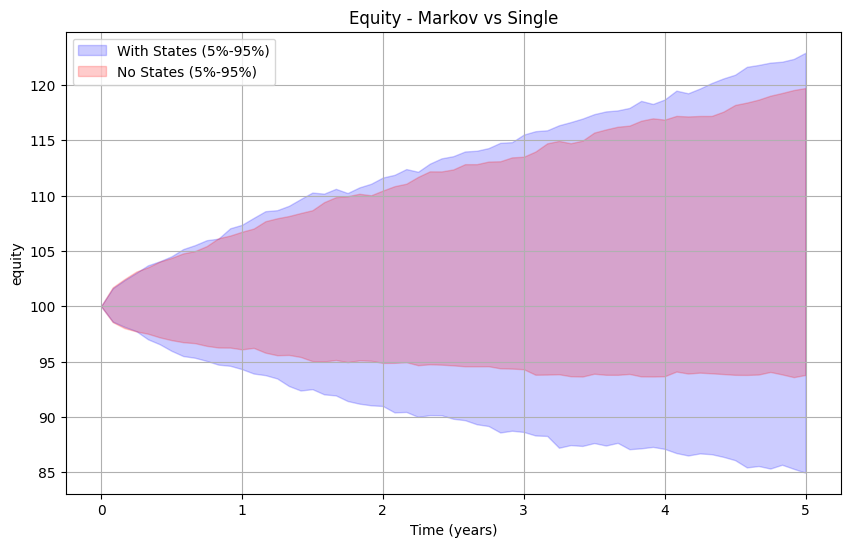

In [ ]:
gse.plot_5_95_comparison(results_with, results_no, variable='equity', title="Equity - Markov vs Single")

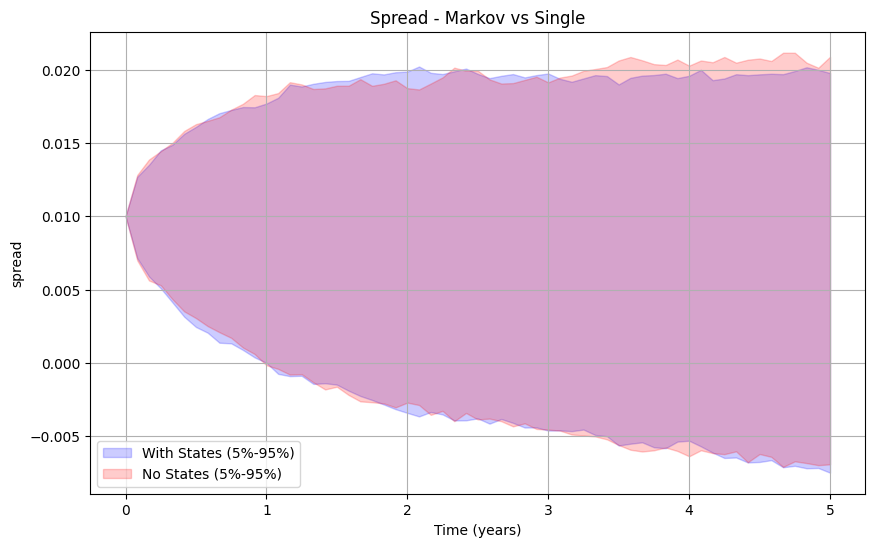

In [ ]:
gse.plot_5_95_comparison(results_with, results_no, variable='spread', title="Spread - Markov vs Single")

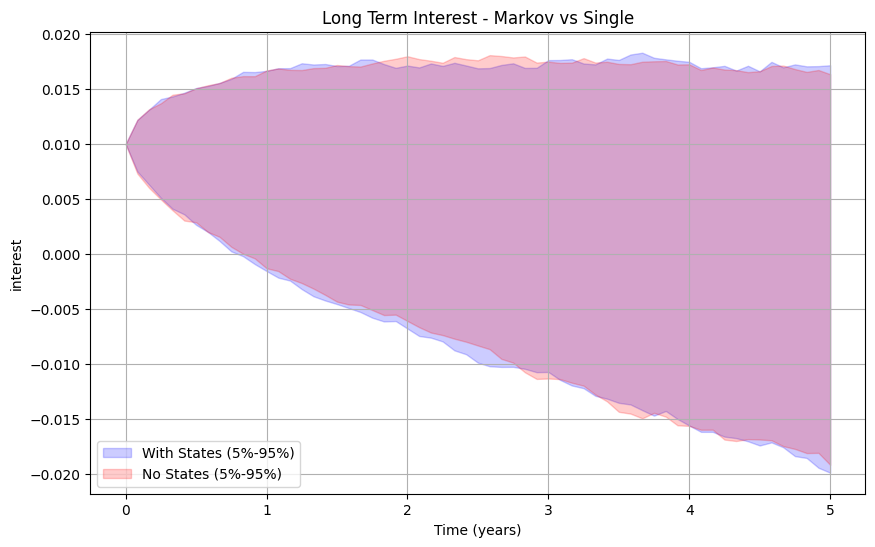

In [ ]:
gse.plot_5_95_comparison(results_with, results_no, variable='interest', title="Long Term Interest - Markov vs Single")

ALM

Check : 
- Is everything in line with what you understood from Online or the Courses ?
- Liability is weird compared to what is proposed in the thesis
- equity & real estate as a percentage of liability ? 
- Check the functionning: how to make it work with the GSE...
- Check the revaluation, veillissement...

In [ ]:
dt = 1/12

##########################################
# Inflation - HMM to identify 2 states
##########################################

inflationEuro["YEAR_MONTH"] = pd.to_datetime(inflationEuro["YEAR_MONTH"])

inflationEuro_data = inflationEuro["inflation"].values

model_inflation = hmm.GaussianHMM(n_components=2, n_iter=100)
X_infl = inflationEuro_data.reshape(-1, 1)  
model_inflation.fit(X_infl)

pred_states_infl = model_inflation.predict(X_infl)
inflationEuro['inflation_state'] = pred_states_infl  

data_state0 = inflationEuro_data[pred_states_infl == 0]
data_state1 = inflationEuro_data[pred_states_infl == 1]

idx_0 = inflationEuro.index[inflationEuro["inflation_state"] == 0]
idx_0_aligned = idx_0[:-1]  
r0 = inflationEuro.loc[idx_0_aligned, "inflation"].values

idx_1 = inflationEuro.index[inflationEuro["inflation_state"] == 1]
idx_1_aligned = idx_1[:-1]  
r1 = inflationEuro.loc[idx_1_aligned, "inflation"].values

vasicek_0 = Vasicek(dt)
a0, mu0, sigma0, _0 = vasicek_0.calibrate_ols(r0)

vasicek_1 = Vasicek(dt)
a1, mu1, sigma1, _1 = vasicek_1.calibrate_ols(r1)

P_infl = model_inflation.transmat_

In [ ]:
##########################################
# Equity - 2-state HMM, each uses Black-Scholes
##########################################

stoxx50E["YEAR_MONTH"] = pd.to_datetime(stoxx50E["YEAR_MONTH"])
stoxx50E_data = stoxx50E["log_returns"].values

model_equity = hmm.GaussianHMM(n_components=2, n_iter=1000)
X_eq = stoxx50E_data.reshape(-1, 1)  
model_equity.fit(X_eq)

pred_states_eq = model_equity.predict(X_eq)
stoxx50E["stocks_state"] = pred_states_eq

data_eq_state0 = stoxx50E_data[pred_states_eq == 0]
data_eq_state1 = stoxx50E_data[pred_states_eq == 1]

black_scholes_stocks0 = BlackScholes(dt)
mu_stock0, sigma_stock0 = black_scholes_stocks0.calibrate(data_eq_state0)

black_scholes_stocks1 = BlackScholes(dt)
mu_stock1, sigma_stock1 = black_scholes_stocks1.calibrate(data_eq_state1)

P_equity = model_equity.transmat_

In [ ]:
##########################################
# Long Term Rate: single-state Vasicek
##########################################

vasicek_long = Vasicek(dt)
a_long, mu_long, sigma_long, results_long = vasicek_long.calibrate_ols(bund_10_years_data)

In [ ]:
##########################################
# Spread: single-state Vasicek
##########################################

vasicek_sprd = Vasicek(dt)
a_spread, mu_spread, sigma_spread, results_spread = vasicek_sprd.calibrate_ols(spreadShortLongRates_data)

In [ ]:
##########################################
# Real Estate: single-state Black–Scholes
##########################################

bs_re = BlackScholes(dt)
mu_re, sigma_re = bs_re.calibrate(IEIFIndex_data)

In [ ]:
vasicek_infl_0 = vasicek_0   
vasicek_infl_1 = vasicek_1  


bs_equity_0 = black_scholes_stocks0
bs_equity_1 = black_scholes_stocks1

bs_re_single = bs_re  

vasicek_interest = vasicek_long
vasicek_spread   = vasicek_sprd

corr_matrix = corr

gse = MarkovChainGSE(
    dt = dt,

    vasicek_infl_0 = vasicek_infl_0,
    vasicek_infl_1 = vasicek_infl_1,
    transmat_infl  = P_infl,

    bs_equity_0    = bs_equity_0,
    bs_equity_1    = bs_equity_1,
    transmat_equity= P_equity,

    vasicek_interest= vasicek_interest,
    vasicek_spread  = vasicek_spread,
    bs_realestate   = bs_re_single,

    corr_matrix     = corr_matrix
)

In [ ]:
n_scenarios = 1000
num_steps   = 60  

res_with = gse.simulate_scenarios_with_states(
    n_scenarios = n_scenarios,
    num_steps   = num_steps,
    infl_init   = 0.02,   
    equity_init = 100.0,  
    interest_init= 0.01,  
    spread_init = 0.002,  
    re_init     = 100.0,
    init_state_infl  = 0, 
    init_state_equity= 0  
)

In [ ]:
res_no = gse.simulate_scenarios_no_states(
    n_scenarios = n_scenarios,
    num_steps   = num_steps,
    infl_init   = 0.02,
    equity_init = 100.0,
    interest_init= 0.01,
    spread_init = 0.002,
    re_init     = 100.0
)

Short-rate range: -0.03998045052755346 0.04086083608402876
0.026601699096164017 0.02 0.005191581608174382 0.27021522625036065 0.005528949680169799 0.006128937104800574


C:\Users\antho\AppData\Local\Temp\ipykernel_256008\3605230544.py:72: RuntimeWarning: divide by zero encountered in scalar divide
  yields[i, s] = np.log(bond_prices[i, s])/i


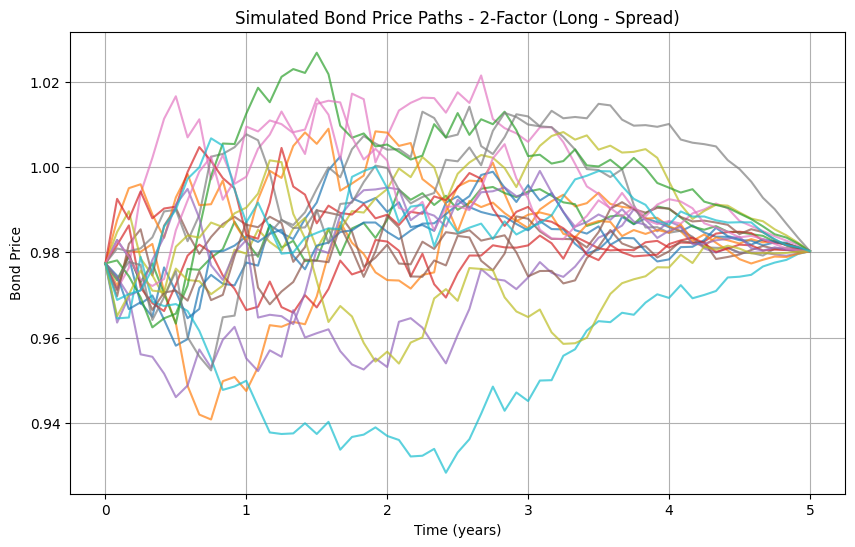

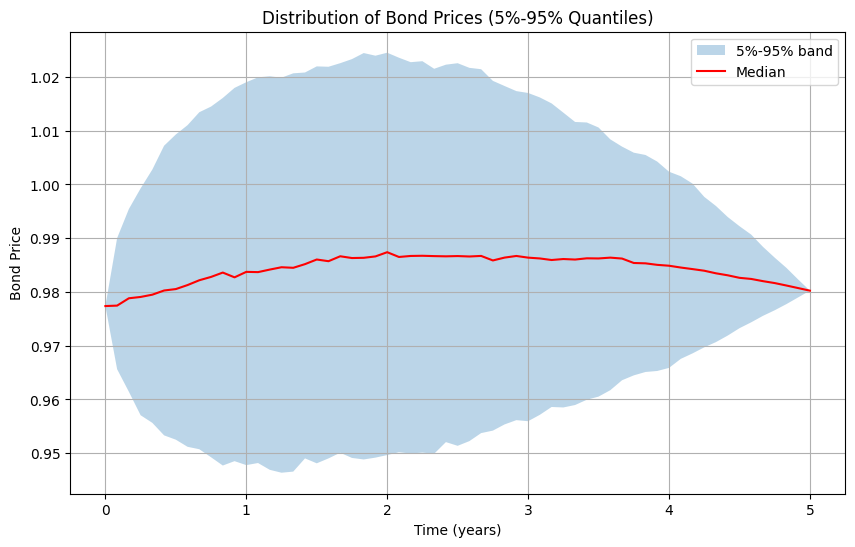

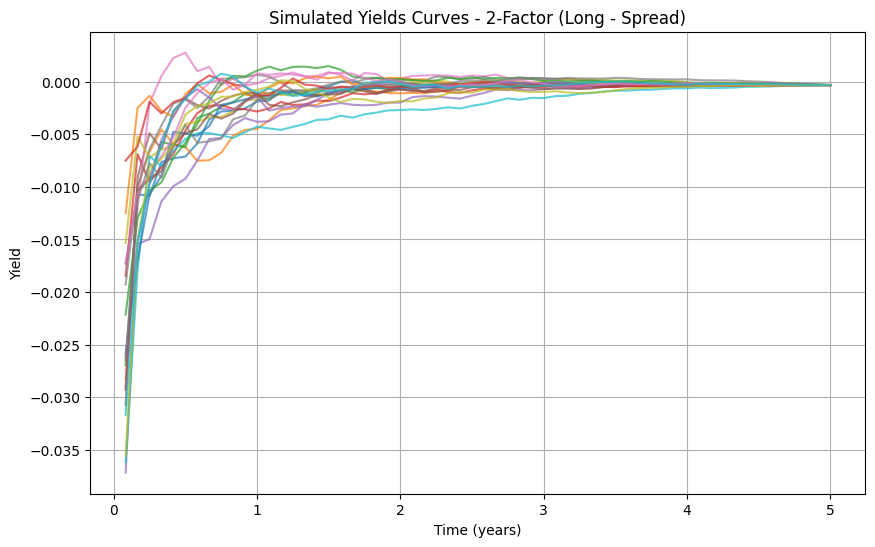

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


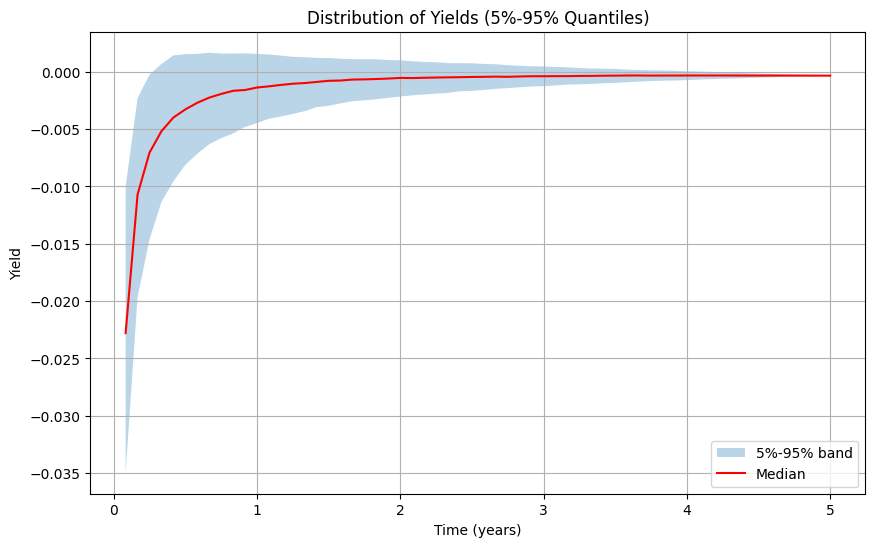

In [ ]:
def vasicek_bond_price(r_t, a, mu, sigma, t, T):
    """
    Single-factor Vasicek bond price, standard formula.
    """
    if T < t:
        return 1.0
    dt_ = T - t
    B = (1 - np.exp(-a * dt_)) / a
    term1 = (mu - sigma**2/(2*a**2)) * (B - dt_)
    term2 = -(sigma**2/(4*a))*B*B
    A = np.exp(term1 + term2)
    return A * np.exp(-B*r_t)

def two_factor_bond_price(l_t, a_l, mu_l, sigma_l,
                          s_t, a_s, mu_s, sigma_s,
                          rho,
                          t, T):
    """
    Approx. 2-factor ZC bond price with short rate = l_t - s_t,
    correlation ~ rho, using a toy correction factor.
    """
    pl = vasicek_bond_price(l_t, a_l, mu_l, sigma_l, t, T)
    p_neg_s = vasicek_bond_price(-s_t, a_s, -mu_s, sigma_s, t, T)
    uncorrelated = pl * p_neg_s
    correction = rho * 0.03 * uncorrelated
    return uncorrelated - correction

def plot_bond_prices(
    scenario_results,
    vasicek_long,    
    vasicek_spread,  
    rho,
    dt,
    T_maturity=5.0,
    max_paths_to_plot=20
):
    """
    1. Extract 'interest' and 'spread' from scenario_results.
    2. Compute bond prices (ZC) for each time/scenario via two_factor_bond_price.
    3. Plot:
        - A few scenario lines
        - 5%-95% percentile band over time
    """

    paths_interest = scenario_results["interest"]  
    paths_spread   = scenario_results["spread"]

    min_rate = np.min(paths_interest - paths_spread)  
    max_rate = np.max(paths_interest - paths_spread)
    print("Short-rate range:", min_rate, max_rate)

    
    n_times, n_scenarios = paths_interest.shape
    
    bond_prices = np.zeros_like(paths_interest)
    yields = np.zeros_like(paths_interest)

    print(vasicek_long.a, 0.02, vasicek_long.sigma,
                vasicek_spread.a, vasicek_spread.mu, vasicek_spread.sigma,)
    
    for i in range(n_times):
        t_i = i * dt
        for s in range(n_scenarios):
            l_t = paths_interest[i, s]
            sp_t= paths_spread[i, s]
            bond_prices[i, s] = two_factor_bond_price(
                l_t, vasicek_long.a, vasicek_long.mu, vasicek_long.sigma,
                sp_t, vasicek_spread.a, vasicek_spread.mu, vasicek_spread.sigma,
                rho,
                t_i, T_maturity
            )
            yields[i, s] = np.log(bond_prices[i, s])/i
    
    time_axis = np.arange(n_times) * dt

    plt.figure(figsize=(10,6))
    for s in range(min(n_scenarios, max_paths_to_plot)):
        plt.plot(time_axis, bond_prices[:, s], alpha=0.7)
    plt.title("Simulated Bond Price Paths - 2-Factor (Long - Spread)")
    plt.xlabel("Time (years)")
    plt.ylabel("Bond Price")
    plt.grid(True)
    plt.show()
    
    q5  = np.quantile(bond_prices, 0.05, axis=1)
    q95 = np.quantile(bond_prices, 0.95, axis=1)
    median = np.median(bond_prices, axis=1)

    plt.figure(figsize=(10,6))
    plt.fill_between(time_axis, q5, q95, alpha=0.3, label="5%-95% band")
    plt.plot(time_axis, median, label="Median", color='red')
    plt.title("Distribution of Bond Prices (5%-95% Quantiles)")
    plt.xlabel("Time (years)")
    plt.ylabel("Bond Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,6))
    for s in range(min(n_scenarios, max_paths_to_plot)):
        plt.plot(time_axis, yields[:, s], alpha=0.7)
    plt.title("Simulated Yields Curves - 2-Factor (Long - Spread)")
    plt.xlabel("Time (years)")
    plt.ylabel("Yield")
    plt.grid(True)
    plt.show()

    q5_y  = np.quantile(yields, 0.05, axis=1)
    q95_y = np.quantile(yields, 0.95, axis=1)
    median_y = np.median(yields, axis=1)

    plt.figure(figsize=(10,6))
    plt.fill_between(time_axis, q5_y, q95_y, alpha=0.3, label="5%-95% band")
    plt.plot(time_axis, median_y, label="Median", color='red')
    plt.title("Distribution of Yields (5%-95% Quantiles)")
    plt.xlabel("Time (years)")
    plt.ylabel("Yield")
    plt.legend()
    plt.grid(True)
    plt.show()

    return bond_prices

rho_approx = gse.corr_matrix.to_numpy()[1,4]  

bond_prices = plot_bond_prices(
    scenario_results = res_with,
    vasicek_long     = vasicek_long,
    vasicek_spread   = vasicek_spread,
    rho              = rho_approx,
    dt               = 1/12,      
    T_maturity       = 5.0,       
    max_paths_to_plot= 20
)

Neural Network for Inflation Modeling

In [ ]:
import torch
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
inflationEuro.set_index('YEAR_MONTH', inplace=True)
inflationEuro

,inflation
YEAR_MONTH,
2003-03-01,0.024
2003-04-01,0.021
2003-05-01,0.018
2003-06-01,0.020
2003-07-01,0.019
...,...
2020-09-01,-0.003
2020-10-01,-0.003
2020-11-01,-0.003


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
inflation_scaled = scaler.fit_transform(inflationEuro[['inflation']])  

In [ ]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i : i + seq_length]     
        y = data[i + seq_length]        
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 12
X, y = create_sequences(inflation_scaled, SEQ_LENGTH)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (203, 12, 1)
y shape: (203, 1)


In [ ]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Train samples:", len(X_train))
print("Test samples :", len(X_test))

Train samples: 162
Test samples : 41


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class LSTMInflation(nn.Module):
    def __init__(self, hidden_size=32, num_layers=1):
        super(LSTMInflation, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  

    def forward(self, x):
        batch_size = x.size(0)
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  

        out = out[:, -1, :]  
        
        out = self.fc(out)  
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = LSTMInflation(hidden_size=32, num_layers=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
EPOCHS = 30
model.train()

for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze() 
        loss = criterion(outputs, batch_y.squeeze())
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * batch_X.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.6f}")

Epoch [5/30], Loss: 0.038652
Epoch [10/30], Loss: 0.032053
Epoch [15/30], Loss: 0.021975
Epoch [20/30], Loss: 0.019116
Epoch [25/30], Loss: 0.016692
Epoch [30/30], Loss: 0.014284


In [ ]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        pred = model(batch_X).squeeze()
        predictions.append(pred.cpu().numpy())
        actuals.append(batch_y.cpu().numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

mse = np.mean((predictions - actuals)**2)
rmse = np.sqrt(mse)
print("Test RMSE (scaled):", rmse)

Test RMSE (scaled): 0.17875873


In [ ]:
predictions_reshaped = predictions.reshape(-1, 1)
actuals_reshaped = actuals.reshape(-1, 1)

inverted_predictions = scaler.inverse_transform(predictions_reshaped)
inverted_actuals = scaler.inverse_transform(actuals_reshaped)

mse_orig = np.mean((inverted_predictions - inverted_actuals)**2)
rmse_orig = np.sqrt(mse_orig)
print("Test RMSE (original scale):", rmse_orig)

Test RMSE (original scale): 0.0047132545


In [ ]:
history_12 = inflation_scaled[-12:].copy()  

model.eval()
future_months = 24
predictions_scaled = []

current_history = history_12.copy()  

for step in range(future_months):
    X_input = torch.tensor(current_history, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_scaled = model(X_input).item()  
    
    predictions_scaled.append(pred_scaled)
    
    new_row = np.array([[pred_scaled]], dtype=np.float32)
    current_history = np.concatenate([current_history, new_row], axis=0)
    current_history = current_history[-12:]  
    
predictions_scaled = np.array(predictions_scaled)

In [ ]:
predictions_scaled_reshaped = predictions_scaled.reshape(-1, 1)
future_inflation = scaler.inverse_transform(predictions_scaled_reshaped).flatten()

C:\Users\antho\AppData\Local\Temp\ipykernel_138640\3083250719.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date,


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x0000023F01885C90>.

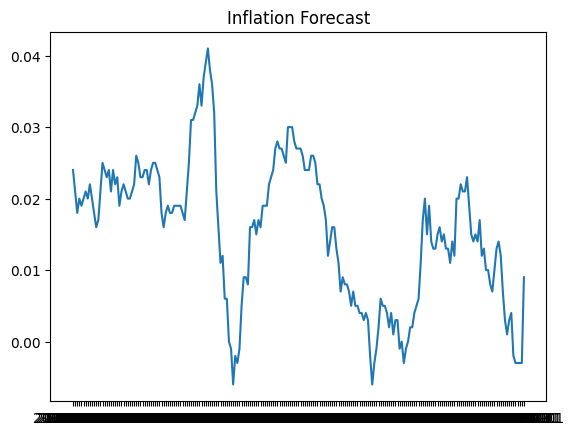

In [ ]:
import matplotlib.pyplot as plt

historical_inflation = inflationEuro['inflation'] 
last_date = historical_inflation.index[-1]

future_dates = pd.date_range(start=last_date, 
                             periods=future_months, 
                             freq='M')

forecast_series = pd.Series(future_inflation, index=future_dates)

plt.figure()
plt.title("Inflation Forecast")
plt.plot(historical_inflation, label="Historical Inflation")
plt.plot(forecast_series, label="Predicted Inflation")
plt.legend()
plt.show()

Quantum Machine Learning

In [ ]:
import qiskit
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import Options
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_ibm_provider import IBMProvider

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
from torchmetrics import MeanAbsoluteError, MeanSquaredError

from typing import Optional
from tqdm import tqdm


sns.set_theme()
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

C:\Users\antho\AppData\Local\Temp\ipykernel_22924\3244436987.py:12: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [ ]:
inflationEuro = pd.read_csv('inflation_euro_processed.csv')

In [ ]:
inflationEuro.set_index('YEAR_MONTH', inplace=True)
inflationEuro

,inflation
YEAR_MONTH,
2003-03-01,0.024
2003-04-01,0.021
2003-05-01,0.018
2003-06-01,0.020
2003-07-01,0.019
...,...
2020-09-01,-0.003
2020-10-01,-0.003
2020-11-01,-0.003


In [ ]:
n = len(inflationEuro)

train_df = inflationEuro[0:int(n*0.8)]
valid_df = inflationEuro[int(n*0.8):int(n*0.9)]
test_df = inflationEuro[int(n*0.9):]

In [ ]:
def time_window_batch(input_data, window, batch_size):
    window_data = []
    L = len(input_data)
    for i in range(0, L - window, batch_size):
        train_series_batch = []
        train_label_batch = []
        for j in range(batch_size):
            train_series = input_data[i+j:i+j+window]
            train_label = input_data[i+j+window:i+j+window+1]
            train_series_batch.append(train_series)
            train_label_batch.append(train_label)
        window_data.append((np.array(train_series_batch), np.array(train_label_batch)))
    return window_data

length=5
train_window=time_window_batch(train_df,length,  1)
valid_window=time_window_batch(valid_df,length, 1)

test_window=time_window_batch(test_df,length, 1) 

In [ ]:
def create_pauli_ops(q):
    if not isinstance(q, int) or q <= 0:
        raise ValueError("q must be a positive integer")
    
    pauli_ops = []
    for i in range(q):
        pauli_str = "I" * i + "Z" + "I" * (q - i - 1)
        pauli_op = SparsePauliOp.from_list([(pauli_str,1)])
        pauli_ops.append(pauli_op)
    
    return pauli_ops

In [ ]:
class QLSTM(nn.Module):
    def __init__(self,
                 input_size: int,
                 num_hiddens: int,
                 batch_size: int,
                 backend,
                 n_layers: Optional[int] = 1, 
                 n_qubits: Optional[int] = 1,
                 feature_map: QuantumCircuit = None,
                 ansatz: QuantumCircuit = None,
                 cx_layer: bin=False,
                 xyz_order: str = None,
                 xyz_factor: str= None,
                 activation: torch.functional= None,
                 clamp=False,
                 ):
        super(QLSTM, self).__init__()
        self.input_size = input_size
        self.num_hiddens = num_hiddens
        self.batch_size=batch_size
        self.backend=backend
        self.n_layers = n_layers
        self._qlayers = {}
        self.activation=activation
        self.clamp=clamp

        ####### Feature Map #######
        qc_encoding = QuantumCircuit(n_qubits)

        thet= ParameterVector('x',n_qubits)
        for i in range(n_qubits):                   
             qc_encoding.ry(thet[i],i)

        feature_map=qc_encoding

        ####### Vartiational Part ######
        qc_var_rot = TwoLocal(3, ['ry'],reps=0, name = 'Variational Block - ri') #Ansatz 999
  
        ansatz= qc_var_rot

        # quantum layers
        self._construct_quantum_layers(feature_map, ansatz)

        # classical layers
        self.clayer_in = nn.Linear(input_size + num_hiddens, n_qubits,bias=False)
        self.clayer_out = nn.Linear(n_qubits, num_hiddens,bias=False)

    def _construct_quantum_layers(self, feature_map, ansatz):
        for layer_name in ['forget', 'input', 'update', 'output']:
            # define the layer using EstimatorQNN from qiskit ml
            n_inputs = feature_map.num_qubits
            qc = QuantumCircuit(n_inputs)
            qc.append(feature_map, range(n_inputs))
            qc.append(ansatz, range(n_inputs))

            input_params = list(feature_map.parameters)
            weight_params = list(ansatz.parameters)

            obs = create_pauli_ops(n_inputs)
             # Noise model 
            noisy_estimator = AerEstimator(
                            backend_options={
                                "method": "density_matrix",
                                "coupling_map": self.backend['coupling'],
                                "noise_model": self.backend['noise'],
                            },
                            run_options={
                                "seed": self.backend['seed'], 
                                "shots": self.backend['shots'], 
                                "resilience_level":self.backend['res_level'] },
                            transpile_options={"seed_transpiler": self.backend['seed']},
                        )
            layer = EstimatorQNN(
                            estimator=noisy_estimator,
                            circuit=qc,
                            input_params=input_params,
                            weight_params=weight_params,
                            input_gradients=True,
                            observables=obs,
                            )
            initial_weights = Tensor(np.random.normal(0,0.01,len(weight_params)))

            self._qlayers[layer_name] = TorchConnector(layer, initial_weights=initial_weights)

    def forward(self,
                x: Tensor,
                H_C: Optional[Tensor] = None):
        if H_C is None:
            H = torch.zeros(self.batch_size, self.num_hiddens)
            C = torch.zeros(self.batch_size, self.num_hiddens)
        else:
            H, C = H_C.detach()
        outputs = []
        for X in x:      
            X=X.reshape((x.shape[1],x.shape[2]))
            V_t = torch.cat((H, X), dim=1)
            x_in = self.clayer_in(V_t)

            I = torch.sigmoid(self.clayer_out(self._qlayers['input'](x_in)))
            F = torch.sigmoid(self.clayer_out(self._qlayers['forget'](x_in)))
            O = torch.sigmoid(self.clayer_out(self._qlayers['output'](x_in)))
            C_tilde = torch.tanh(self.clayer_out(self._qlayers['update'](x_in)))
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H.unsqueeze(0))
        outputs = torch.cat(outputs, dim=0)
        return outputs, (H, C)

In [ ]:
class QModel(nn.Module):

    def __init__(self, 
                    input_dim,
                    hidden_dim, 
                    batch_size, 
                    target_size, 
                    n_qubits=0, 
                    backend='default.qubit',
                    ansatz=None,

                 ):
        super(QModel, self).__init__()

        seed = 71
        np.random.seed = seed
        torch.manual_seed=seed
        
        self.qlstm = QLSTM(input_dim, 
                        hidden_dim, 
                        batch_size,
                        backend=backend, 
                        n_qubits=n_qubits,
                        ansatz=ansatz)
        # The linear layer that maps from hidden state space to target space
        self.dense = nn.Linear(hidden_dim, target_size)

    def forward(self, x):
        qlstm_out, _ = self.qlstm(x)
        dense_out = self.dense(qlstm_out)
        out_scores=dense_out
        # out_scores = F.log_softmax(dense_out, dim=1)
        return out_scores

In [ ]:
for backend in provider.backends():
    print(backend.name)

ibm_kyiv
ibm_brisbane
ibm_sherbrooke


In [ ]:
provider = IBMProvider('2ff98278712fb8aac3f1cb3a9a8c0f0811208a171ca3acb5ffd23a2ead5a872dacc9eb2a4d3c1556586d0faba765239daf41b5b2b88edb82cf7e28b56502ff32')
IBMProvider.save_account('2ff98278712fb8aac3f1cb3a9a8c0f0811208a171ca3acb5ffd23a2ead5a872dacc9eb2a4d3c1556586d0faba765239daf41b5b2b88edb82cf7e28b56502ff32',overwrite=True)
backend = provider.get_backend('ibm_kyiv')
noise_model = NoiseModel.from_backend(backend)

In [ ]:
from qiskit_aer import AerSimulator

###############################
# Change manually this params
###############################
input_size = 1
hidden_dim = 4
n_qubits = 3
n_epochs = 10
target_size = 1
batch_size= 1

print(f"Input dim:    {input_size}")
print(f"LSTM output size: {hidden_dim}")
print(f"Number of qubits: {n_qubits}")
print(f"Training epochs:  {n_epochs}")


# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
backend = AerSimulator(shots=10) 

shots = 100
model = QModel(input_size,
                hidden_dim,
                batch_size,
                target_size=target_size,
                n_qubits=n_qubits,
                backend={
                    'backend':backend, 
                    'coupling':coupling_map,
                    'noise':noise_model,
                    'seed': 71, 
                    'shots': shots,
                    'res_level': 1}, 
                ansatz=None,
                )
loss_function = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01, momentum=0.2)



model.qlstm.clayer_in.requires_grad_(False)
model.qlstm.clayer_out.requires_grad_(False)

history = {
    'train_loss': [],
    'valid_loss': [],
    'mae': [],
    'mse': []
}

for epoch in range(n_epochs):
    train_losses = []
    preds = []
    targets = []
    model.train()
    
    for i,X in enumerate(tqdm(train_window)):
        if i ==len(train_window)-1:
            break;
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        # Step 3. Run our forward pass.
        X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
        out_scores = model(X_in)[-1]

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        label= torch.Tensor([X[1]]).reshape((batch_size,1))
        loss = loss_function(out_scores,label)
        loss.backward()
        optimizer.step()
        train_losses.append(float(loss))

        preds.append(torch.Tensor(out_scores.detach()))
        targets.append(label)
        
    valid_losses = []
    model.eval()     
    for i,X in enumerate(tqdm(valid_window)):
        if i ==len(valid_window)-1:
            break;
        X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
        try:
            out_scores = model(X_in)[-1]
        except Exception as e:
            print("There was a mistake in the qiskit code: ",e) 
            continue     
        label= torch.Tensor([X[1]]).reshape((batch_size,1))
        loss = loss_function(out_scores,label)
        valid_losses.append(float(loss))

    avg_loss_train = np.mean(train_losses)
    avg_loss_valid = np.mean(valid_losses)
    history['train_loss'].append(avg_loss_train)
    history['valid_loss'].append(avg_loss_valid)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    mean_abs_error = MeanAbsoluteError()
    mae=mean_abs_error(preds, targets)
    mean_sqrt_error = MeanSquaredError()
    mse=mean_sqrt_error(preds, targets)
    history['mae'].append(mae)
    history['mse'].append(mse)
    print(f"Epoch {epoch + 1} / {n_epochs}: Loss = {avg_loss_train:.3f} Valid Loss: {avg_loss_valid:.3f} MAE = {mae:.4f} MSE = {mse:.4f}")

C:\Users\antho\AppData\Local\Temp\ipykernel_2940\129615461.py:42: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  self._construct_quantum_layers(feature_map, ansatz)
C:\Users\antho\AppData\Local\Temp\ipykernel_2940\129615461.py:42: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  self._construct_quantum_layers(feature_map, ansatz)
C:\Users\antho\AppData\Local\Temp\ipykernel_2940\129615461.py:73: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  layer = EstimatorQNN(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit_machine_

Input dim:    1
LSTM output size: 4
Number of qubits: 3
Training epochs:  10


  0%|          | 0/167 [00:00<?, ?it/s]C:\Users\antho\AppData\Local\Temp\ipykernel_2940\617912735.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  label= torch.Tensor([X[1]]).reshape((batch_size,1))
 27%|██▋       | 45/167 [27:20<1:14:08, 36.46s/it]


KeyboardInterrupt: 

In [ ]:
predictions=np.array([])
test_labels=np.array([])
for i,y in enumerate(test_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model(test_tensor)[-1]
        predictions=np.append(predictions,pred.detach().numpy())
        test_labels= np.append(test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
    except: 
        pred=1
        predictions=np.append(predictions,pred)
        test_labels= np.append(test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
t_predictions=torch.from_numpy(predictions)
t_test_labels=torch.from_numpy(test_labels)

mean_abs_error = MeanAbsoluteError()
mae=mean_abs_error(t_predictions, t_test_labels)
mean_sqrt_error = MeanSquaredError()
mse=mean_sqrt_error(t_predictions, t_test_labels)
print("MAE Test",mae)
print("MSE Test",mse)

In [ ]:
plt.plot(np.arange(len(test_df[length:])),test_df[length:], color='blue', label='Test data')
plt.plot(np.arange(len(predictions)),predictions, color='red', label='Predicted data',linestyle='dashed')